# Customer Segmentation

## Step 0 : Setup

### Import Libraries

In [1]:
import ipywidgets
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


In [2]:
# Download the dataset and construct the file path
file_path = f"{kagglehub.dataset_download('shwetabh123/mall-customers')}/Mall_Customers.csv"

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Step 1 : Data Cleaning

In [3]:
# Rename the 'Genre' column to 'Gender'
df.rename(columns={'Genre': 'Gender'}, inplace=True)

# Drop the 'CustomerID' column because it's irrelevant for clustering
df.drop('CustomerID', axis=1, inplace=True)

# Display the first few rows of the DataFrame to confirm the changes
print("DataFrame after renaming 'Genre' and dropping 'CustomerID':\n")
df.head()

DataFrame after renaming 'Genre' and dropping 'CustomerID':



,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


## Step 2 : Exploratory Data Analysis (EDA)

### Data Inspection

In [4]:
df.shape

(200, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [6]:
print("\nMissing values in each column:\n", df.isnull().sum())


Missing values in each column:
 Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [7]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


### Simple Data Visualization

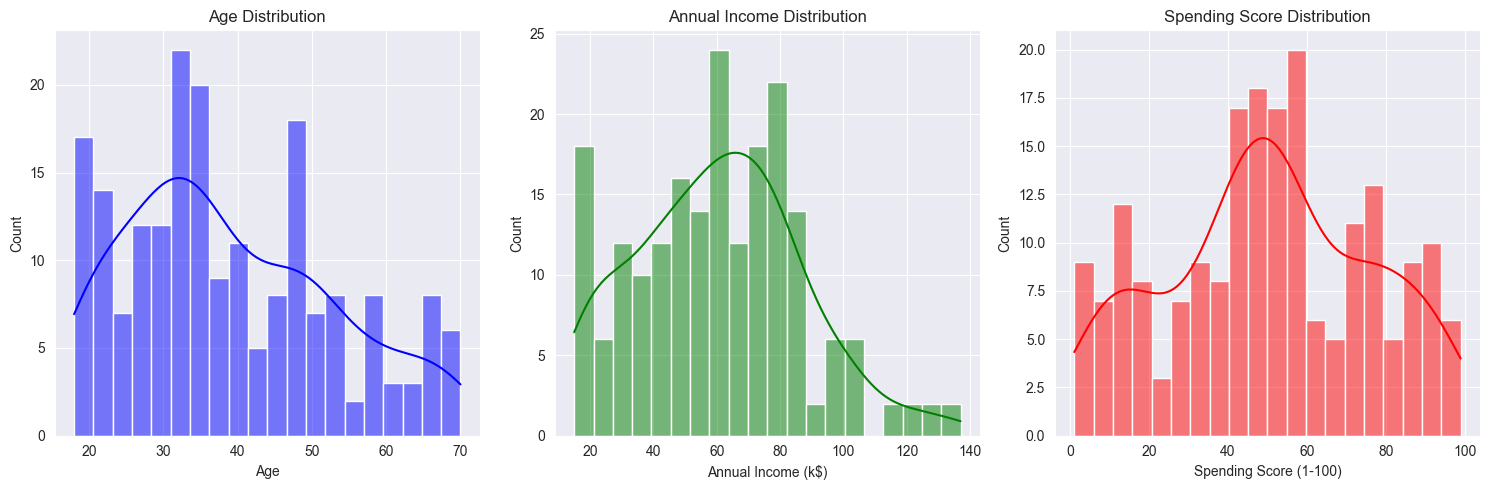

In [8]:
# Create a figure to hold the subplots
plt.figure(figsize=(15, 5))

# Plot for Age
plt.subplot(1, 3, 1)
sns.histplot(df['Age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution')

# Plot for Annual Income
plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], bins=20, kde=True, color='green')
plt.title('Annual Income Distribution')

# Plot for Spending Score
plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], bins=20, kde=True, color='red')
plt.title('Spending Score Distribution')

plt.tight_layout()
plt.show()

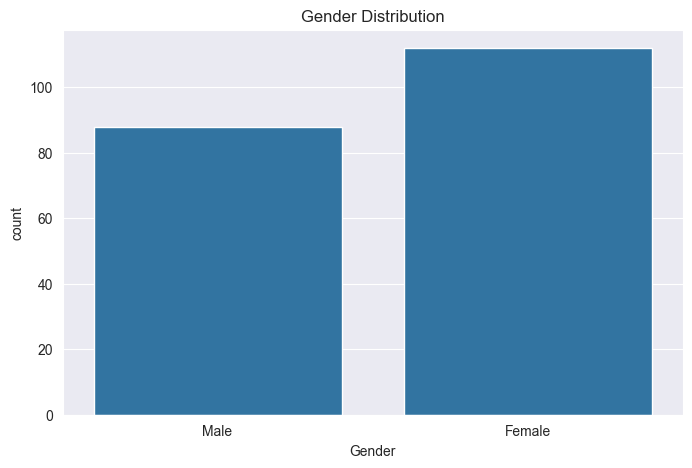

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', data=df)
plt.title('Gender Distribution')
plt.show()

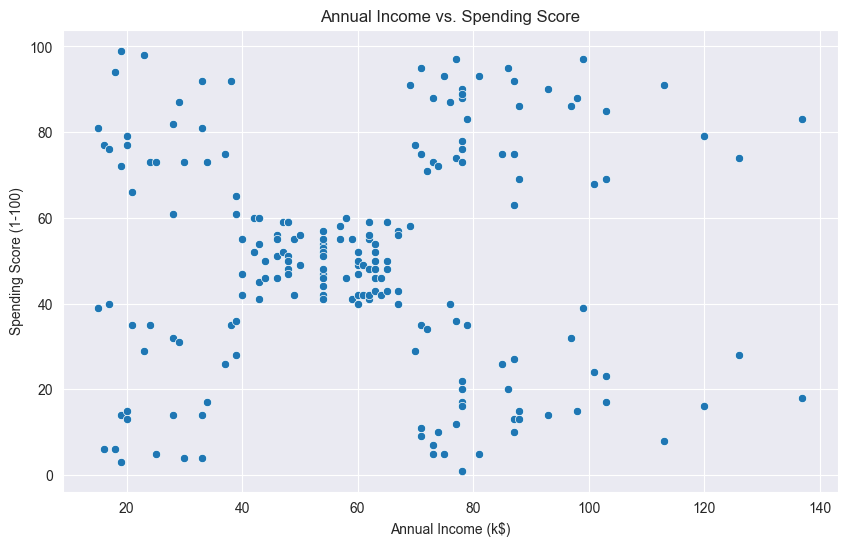

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df)
plt.title('Annual Income vs. Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

### Advanced Data Visualization

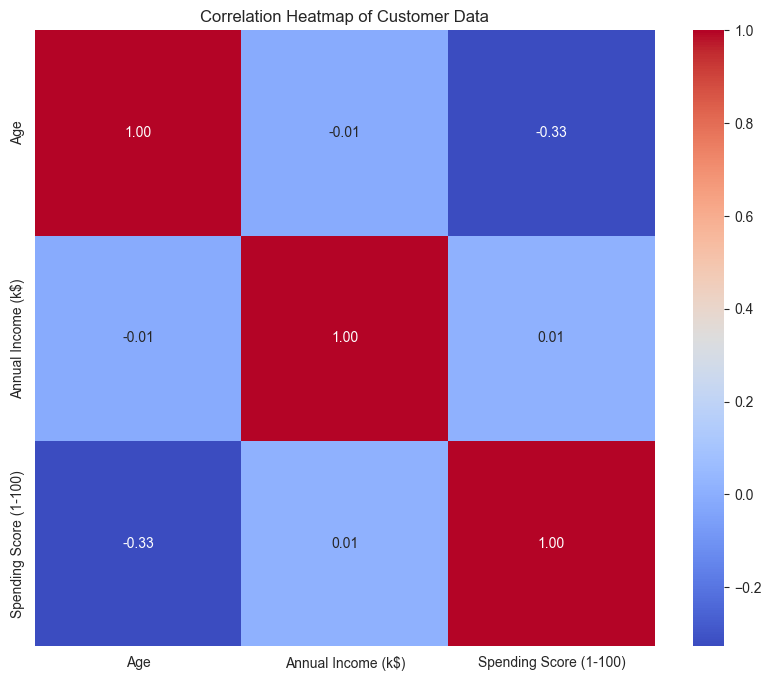

In [11]:
# Calculate the correlation matrix for numerical columns
corr = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()

plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Customer Data')
plt.show()

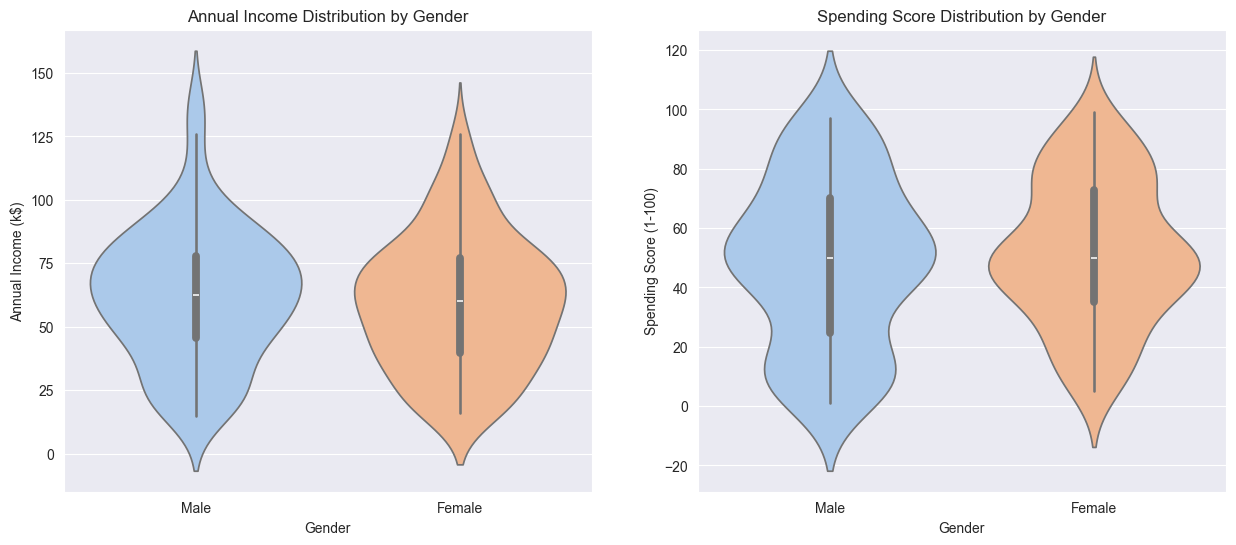

In [12]:
plt.figure(figsize=(15, 6))

# Plot for Annual Income by Gender
plt.subplot(1, 2, 1)
sns.violinplot(x='Gender', y='Annual Income (k$)', data=df, palette='pastel', hue='Gender', legend=False)
plt.title('Annual Income Distribution by Gender')

# Plot for Spending Score by Gender
plt.subplot(1, 2, 2)
sns.violinplot(x='Gender', y='Spending Score (1-100)', data=df, palette='pastel', hue='Gender', legend=False)
plt.title('Spending Score Distribution by Gender')

plt.show()

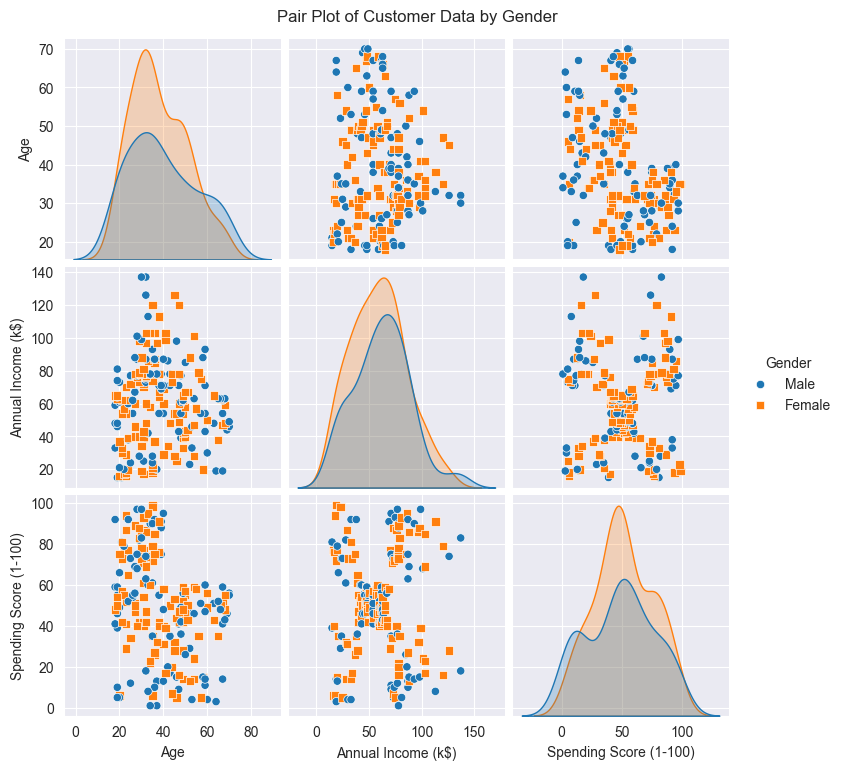

In [13]:
# Pair plot to visualize relationships between all numerical variables
# hue='Gender' will color the points based on the customer's gender
sns.pairplot(df, hue='Gender', markers=['o', 's'])
plt.suptitle('Pair Plot of Customer Data by Gender', y=1.02)
plt.show()

## Step 3 : Data Preprocessing

### Encode Categorical Variables

In [14]:
# Encode the 'Gender' column directly on the df
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

### Feature Scaling

In [15]:
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Fit and transform the numerical columns, updating them in the original df
df[numerical_cols] = StandardScaler().fit_transform(df[numerical_cols])

# Display the first few rows to show the changes
print("DataFrame after in-place Encoding and Scaling:")
df.head()

DataFrame after in-place Encoding and Scaling:


,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,-1.424569,-1.738999,-0.434801
1,0,-1.281035,-1.738999,1.195704
2,1,-1.352802,-1.700830,-1.715913
3,1,-1.137502,-1.700830,1.040418
4,1,-0.563369,-1.662660,-0.395980


## Step 4 : Dimensionality Reduction (PCA)

Explained variance for different numbers of components:
1 components: 0.4095 (40.95%)
2 components: 0.7177 (71.77%)
3 components: 0.9249 (92.49%)

Best number of components: 3
Variance explained with 3 components: 0.9249


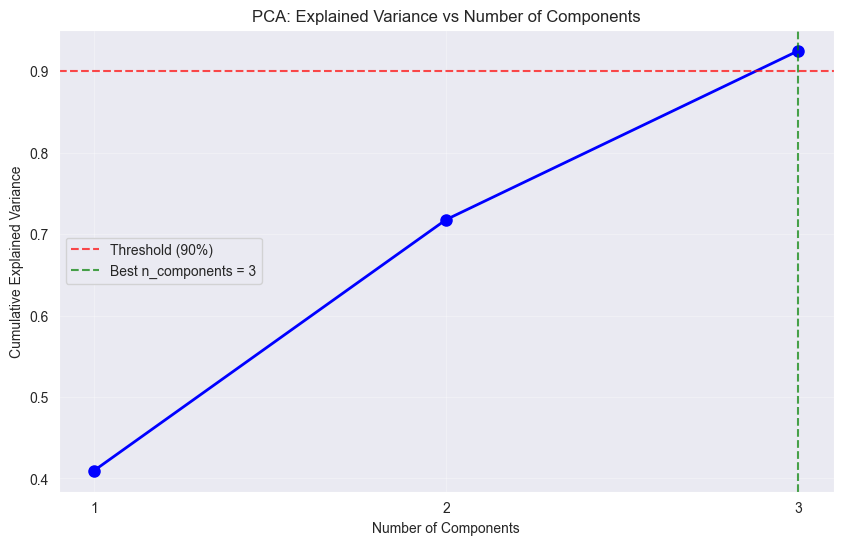

In [16]:
# Exploring best number of components for PCA
explained_variances = []
components_range = range(1, 4) # Testing 1 to 3 components (reduce at least 1 component)

# Test different numbers of components
for n_components in components_range:
    pca_temp = PCA(n_components=n_components)
    pca_temp.fit(df)
    explained_variances.append(sum(pca_temp.explained_variance_ratio_))

# Results
print("Explained variance for different numbers of components:")
for i, variance in enumerate(explained_variances):
    print(f"{i+1} components: {variance:.4f} ({variance*100:.2f}%)")

# Find best number of components
variance_threshold = 0.9  # 90% of variance explained
best_n_components = 1  # Start with 1 component

for i, variance in enumerate(explained_variances):
    if variance >= variance_threshold:
        best_n_components = i + 1
        break
else:
    # If no component meets threshold, use the one that explains most variance
    best_n_components = len(explained_variances)

print(f"\nBest number of components: {best_n_components}")
print(f"Variance explained with {best_n_components} components: {explained_variances[best_n_components-1]:.4f}")

# Visualize the explained variance
plt.figure(figsize=(10, 6))
plt.plot(components_range, explained_variances, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=variance_threshold, color='r', linestyle='--', alpha=0.7, label=f'Threshold ({variance_threshold*100:.0f}%)')
plt.axvline(x=best_n_components, color='g', linestyle='--', alpha=0.7, label=f'Best n_components = {best_n_components}')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs Number of Components')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(components_range)
plt.show()


Using 3 components for visualization
Explained variance ratio: [0.4095285  0.3081674  0.20723465]

Total variance explained: 0.9249305503496911

Top contributing features for each PC:
  PC1: Age(0.71), Spending Score (1-100)(0.71), Annual Income (k$)(0.04)
  PC2: Annual Income (k$)(1.00), Gender(0.04), Spending Score (1-100)(0.03)
  PC3: Spending Score (1-100)(0.71), Age(0.71), Annual Income (k$)(0.01)


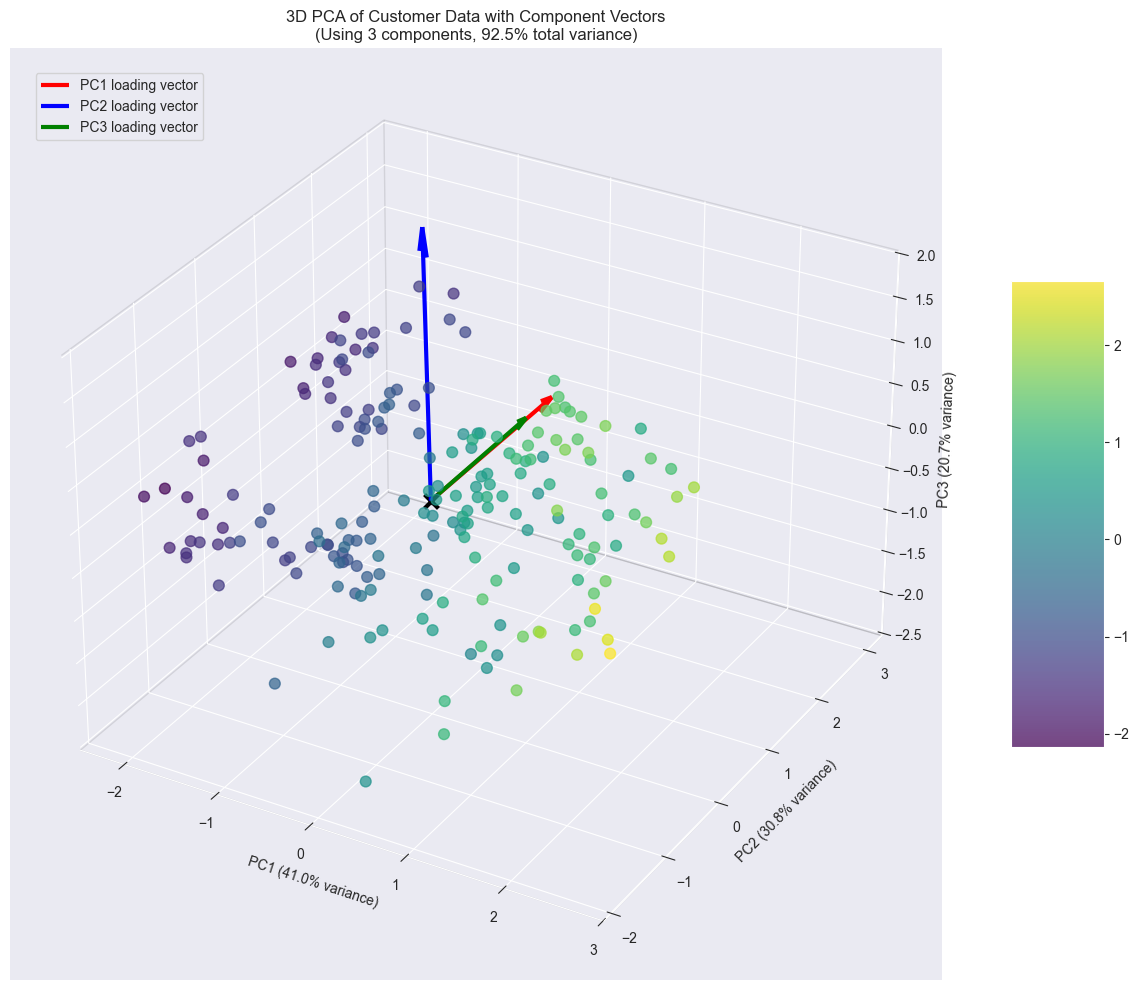

In [17]:
# --- 1. Perform PCA with optimal number of components ---
pca = PCA(n_components=best_n_components)
principal_components = pca.fit_transform(df)

# --- 2. Create a DataFrame with the results ---
pc_columns = [f'PC{i+1}' for i in range(best_n_components)]
pca_df = pd.DataFrame(data=principal_components, columns=pc_columns)
print(f"\nUsing {best_n_components} components for visualization")
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("\nTotal variance explained:", sum(pca.explained_variance_ratio_))

# Make explained variance available regardless of 3D plot
explained_variance = pca.explained_variance_ratio_

# --- 3. Visualization with Matplotlib (3D) ---
if best_n_components >= 3:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Use gradient colors based on PC1 values
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
                        c=pca_df['PC1'], cmap='viridis', s=60, alpha=0.7)

    # Add colorbar
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

    # --- 4. Add PCA component vectors (eigenvectors) ---
    # Get the component loadings (eigenvectors)
    components = pca.components_[:3]  # First 3 components for 3D plot

    # Scale the vectors for better visibility
    scale_factor = 3.0  # Adjust this to make arrows more/less prominent
    center = [0, 0, 0]  # Origin point for the arrows

    # Colors for the component vectors
    colors = ['red', 'blue', 'green']
    labels = ['PC1', 'PC2', 'PC3']

    # Plot component vectors as arrows
    for i, (component, color, label) in enumerate(zip(components, colors, labels)):
        # Calculate arrow end points (scaled)
        end_point = component * scale_factor * np.sqrt(pca.explained_variance_[i])

        # Draw arrow from origin to end point
        ax.quiver(center[0], center[1], center[2],
                 end_point[0], end_point[1], end_point[2],
                 color=color, arrow_length_ratio=0.1, linewidth=3,
                 label=f'{label} loading vector')

    # --- 5. Add feature names ---
    # If you want to show which original features contribute most to each PC
    if hasattr(df, 'columns'):
        feature_names = df.columns
        print(f"\nTop contributing features for each PC:")
        for i in range(min(3, len(components))):
            # Get absolute loadings for this component
            loadings = np.abs(components[i])
            # Get indices of top 3 features
            top_features_idx = np.argsort(loadings)[-3:][::-1]
            top_features = [feature_names[idx] for idx in top_features_idx]
            top_loadings = [loadings[idx] for idx in top_features_idx]

            print(f"  PC{i+1}: {', '.join([f'{feat}({load:.2f})' for feat, load in zip(top_features, top_loadings)])}")

    # Enhanced labeling
    ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
    ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
    ax.set_zlabel(f'PC3 ({explained_variance[2]:.1%} variance)')
    ax.set_title(f'3D PCA of Customer Data with Component Vectors\n(Using {best_n_components} components, {sum(explained_variance):.1%} total variance)')

    # Make axes more visible
    ax.grid(True, alpha=0.3)
    for pane in [ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane]:
        pane.set_edgecolor('black')
        pane.set_alpha(0.1)
        pane.fill = False

    # Add legend for component vectors
    ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))

    # Add origin point for reference
    ax.scatter([0], [0], [0], color='black', s=100, marker='x', linewidth=3, label='Origin')

    plt.tight_layout()
    plt.show()

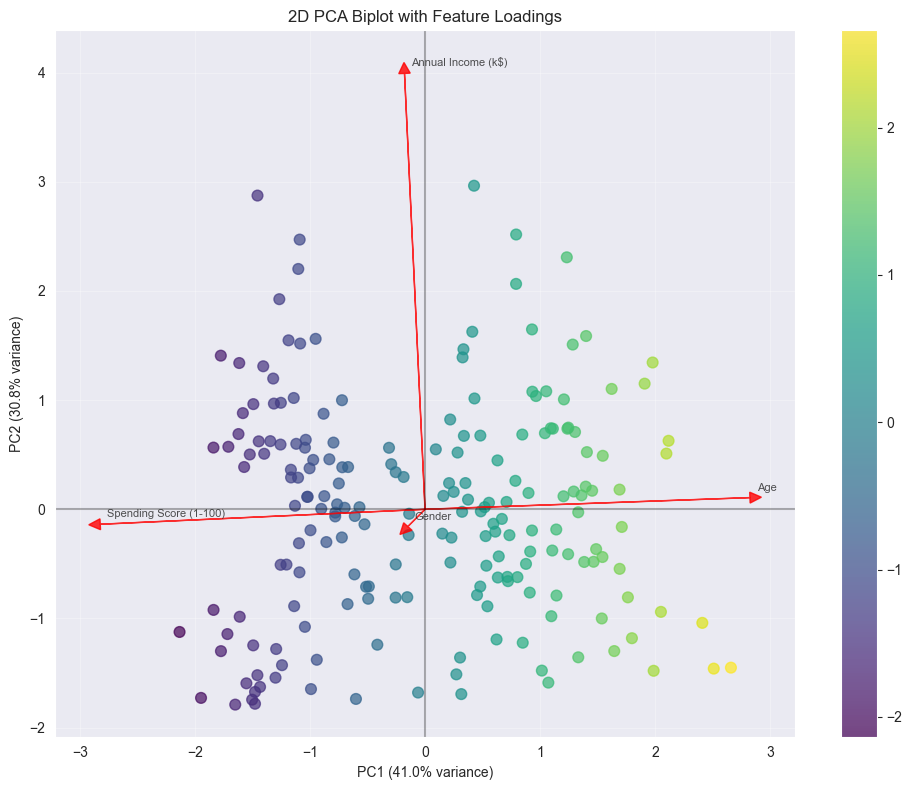

In [18]:
# --- a 2D biplot for better component visualization ---
if best_n_components >= 2:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Plot data points
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'],
                        c=pca_df['PC1'], cmap='viridis', s=60, alpha=0.7)
    plt.colorbar(scatter, ax=ax)

    # Plot component vectors (loadings) for 2D
    scale_factor_2d = 4.0
    for i in range(min(len(df.columns), 5)):  # Show top 5 features for clarity
        loading = pca.components_[:2, i] * scale_factor_2d
        ax.arrow(0, 0, loading[0], loading[1],
                head_width=0.1, head_length=0.1,
                fc='red', ec='red', alpha=0.8)

        # Add feature labels if available
        if hasattr(df, 'columns'):
            ax.annotate(df.columns[i],
                       xy=(loading[0], loading[1]),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)

    ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
    ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
    ax.set_title('2D PCA Biplot with Feature Loadings')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)

    plt.tight_layout()
    plt.show()

## Step 5 : Clustering

### K-Means Clustering

#### Determine Optimal Number of Clusters (K)

Calculating inertia and silhouette scores for different K values...
K	Inertia		Silhouette Score
----------------------------------------
2	389.82		0.3352
3	295.85		0.3571
4	205.68		0.4033
5	168.65		0.4108
6	134.01		0.4275
7	117.06		0.4191
8	103.97		0.4090
9	91.84		0.4219
10	82.64		0.4018

Elbow Method suggests: 5 clusters
Silhouette Analysis suggests: 6 clusters


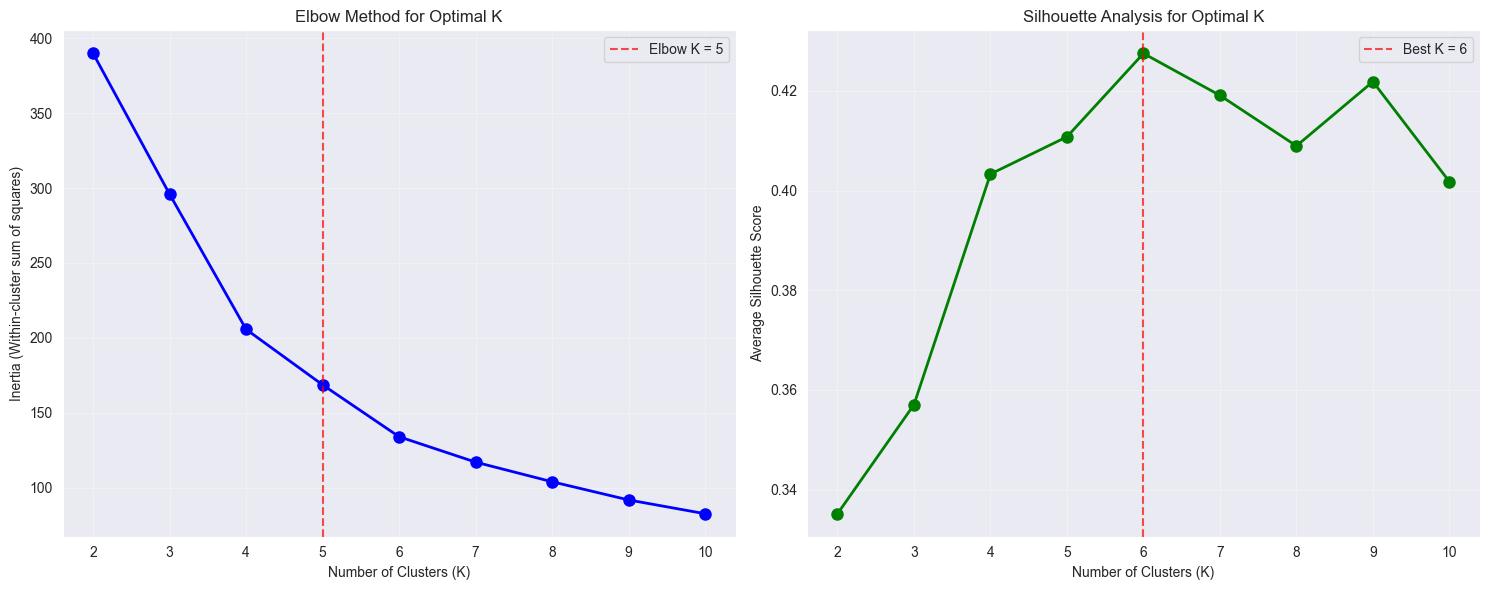

Best K value (Elbow Method): 5
Best K value (Silhouette Score): 6


In [19]:
# --- Elbow Method + Silhouette Score for Optimal K ---
k_range = range(2, 11)  # Test 2 to 10 clusters (silhouette needs at least 2 clusters)
inertias = []
silhouette_scores = []

print("Calculating inertia and silhouette scores for different K values...")
print("K\tInertia\t\tSilhouette Score")
print("-" * 40)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(pca_df)

    # Calculate inertia
    inertias.append(kmeans.inertia_)

    # Calculate silhouette score
    sil_score = silhouette_score(pca_df, cluster_labels)
    silhouette_scores.append(sil_score)

    print(f"{k}\t{kmeans.inertia_:.2f}\t\t{sil_score:.4f}")

# Find optimal K using elbow method
diffs = np.diff(inertias)
diffs2 = np.diff(diffs)

if len(diffs2) > 0:
    elbow_k = k_range[np.argmax(diffs2) + 2]  # +2 because of double diff
else:
    elbow_k = 3  # Default fallback

# Find optimal K using silhouette score (highest score)
silhouette_k = k_range[np.argmax(silhouette_scores)]

print(f"\nElbow Method suggests: {elbow_k} clusters")
print(f"Silhouette Analysis suggests: {silhouette_k} clusters")

# Visualize both methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow Method Plot
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=elbow_k, color='r', linestyle='--', alpha=0.7, label=f'Elbow K = {elbow_k}')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_xticks(k_range)

# Silhouette Score Plot
ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=silhouette_k, color='r', linestyle='--', alpha=0.7, label=f'Best K = {silhouette_k}')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Average Silhouette Score')
ax2.set_title('Silhouette Analysis for Optimal K')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xticks(k_range)

plt.tight_layout()
plt.show()

# Save the optimal K values
best_k_elbow = elbow_k
best_k_silhouette = silhouette_k

print(f"Best K value (Elbow Method): {best_k_elbow}")
print(f"Best K value (Silhouette Score): {best_k_silhouette}")

#### Visualizing both possible K values

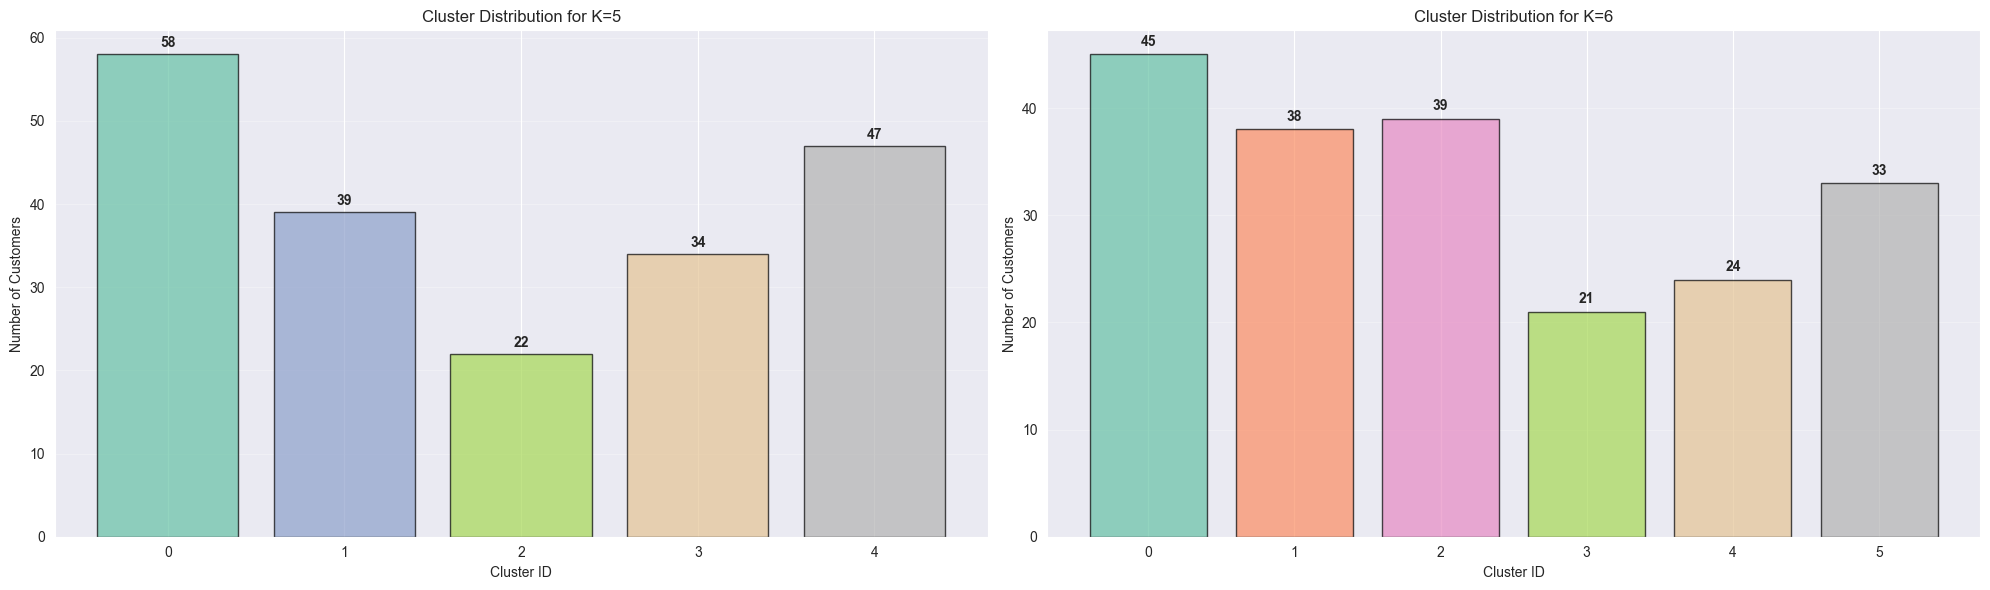

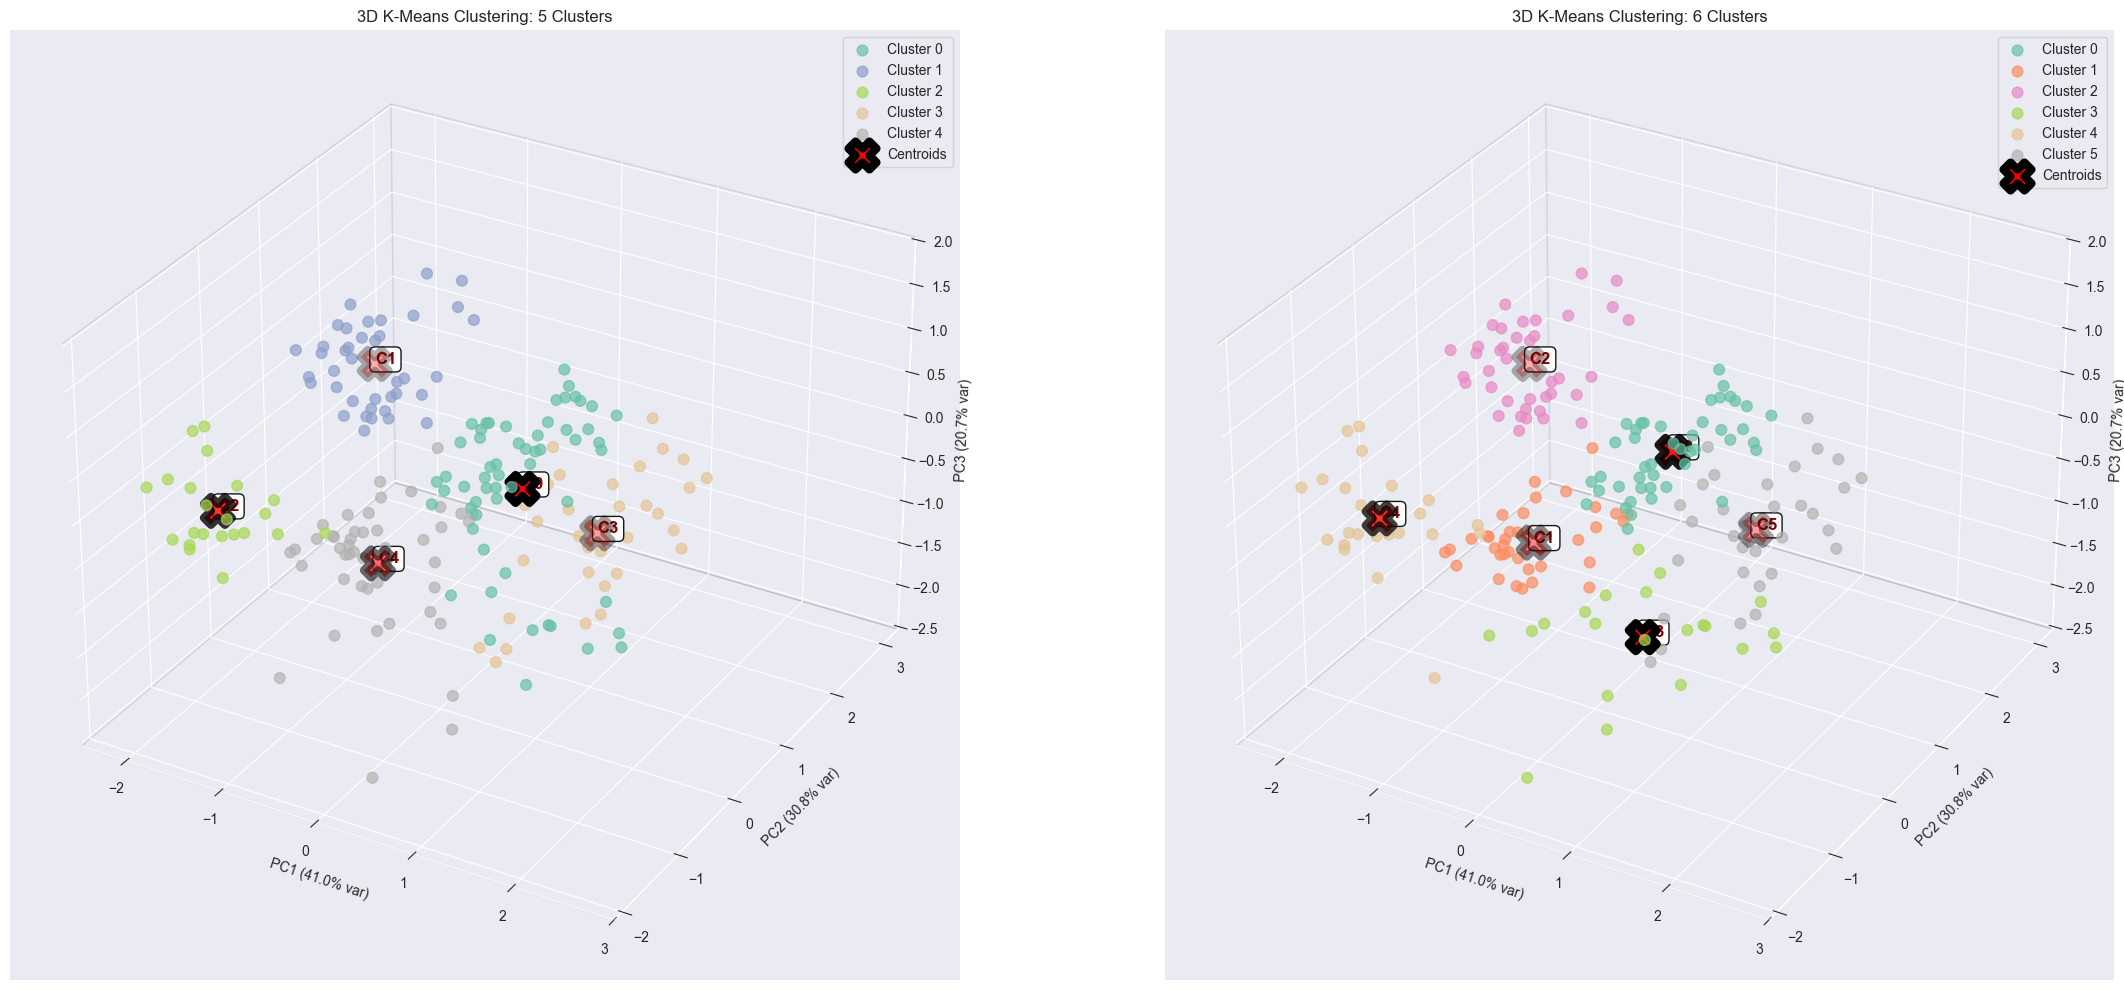

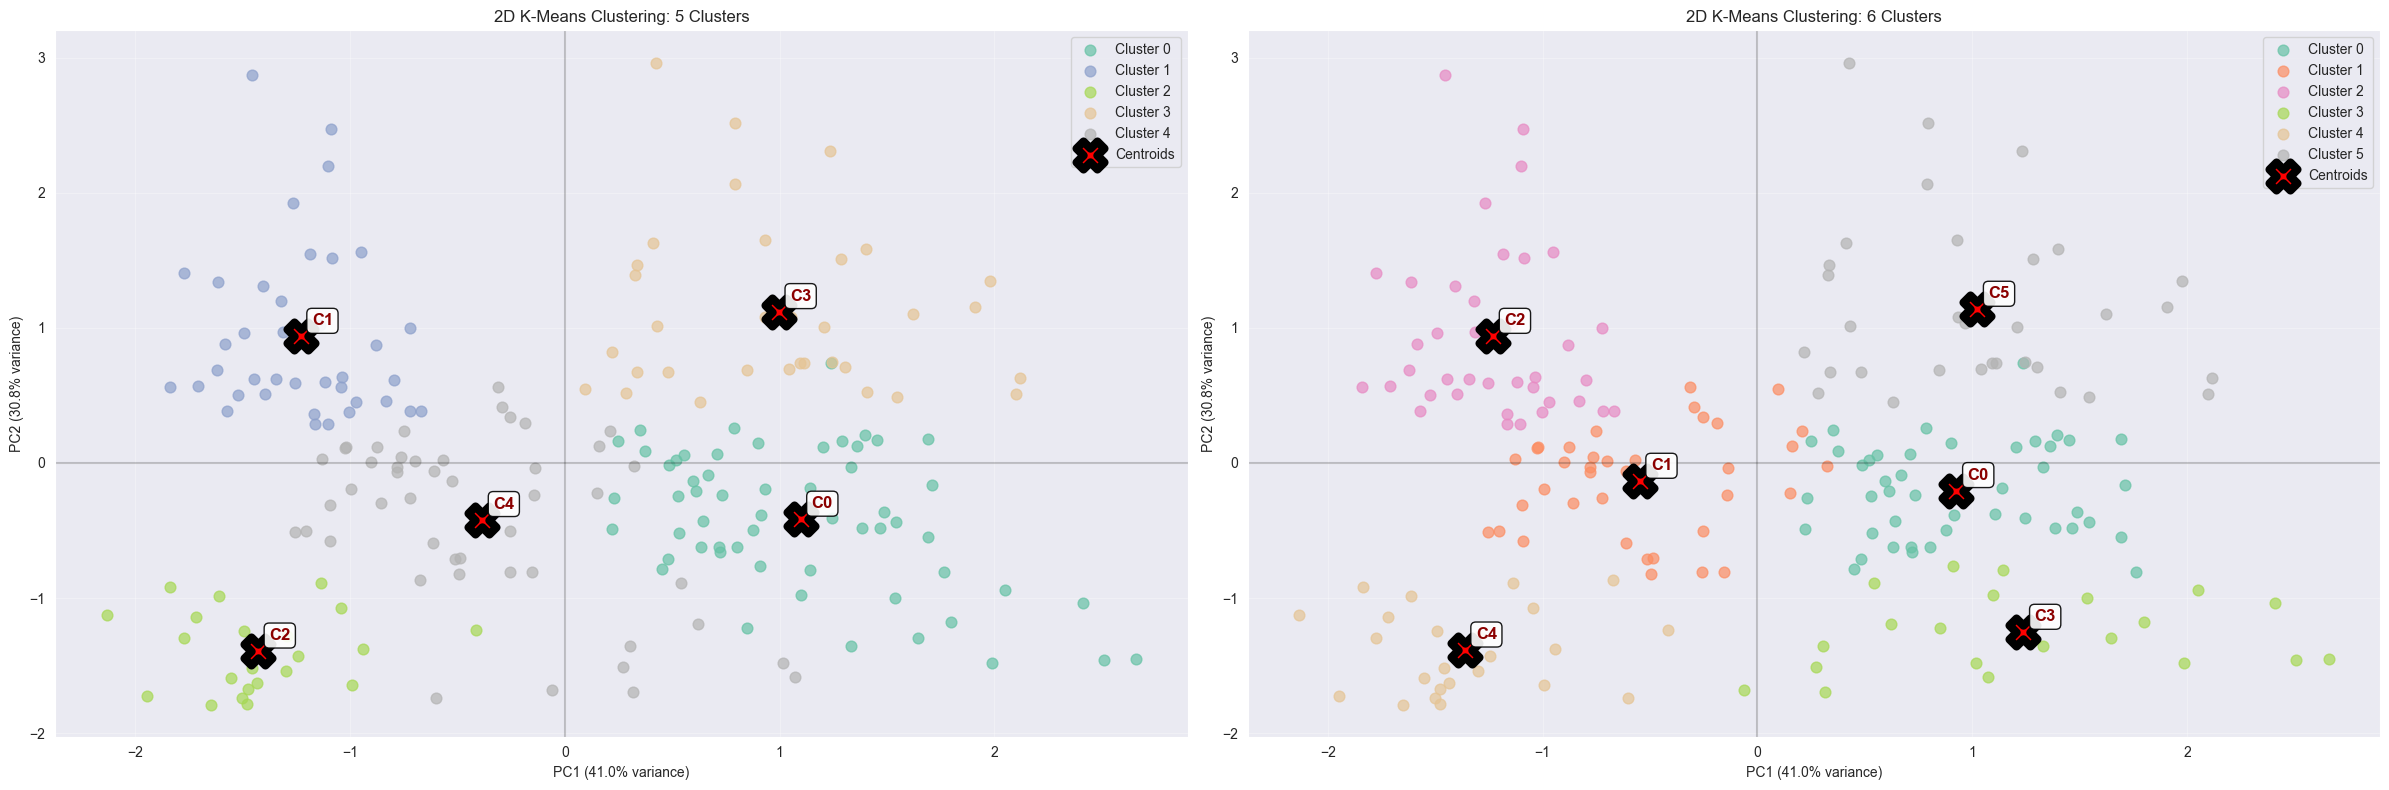

Optimal K chosen: 6


In [20]:
# --- K-Means with both optimal K values ---
cluster_numbers = [best_k_elbow, best_k_silhouette]
kmeans_results = {}

# Fit both models and store results
for k in cluster_numbers:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(pca_df)

    kmeans_results[k] = {
        'model': kmeans,
        'labels': cluster_labels,
        'centroids': kmeans.cluster_centers_,
        'inertia': kmeans.inertia_,
        'silhouette': silhouette_score(pca_df, cluster_labels)
    }

# 1. Histogram Comparison (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for idx, k in enumerate(cluster_numbers):
    cluster_labels = kmeans_results[k]['labels']
    colors = plt.cm.Set2(np.linspace(0, 1, k))

    unique, counts = np.unique(cluster_labels, return_counts=True)

    bars = axes[idx].bar(unique, counts, color=colors[:len(unique)], alpha=0.7, edgecolor='black')

    # Add count labels on top of bars
    for bar, count in zip(bars, counts):
        axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                      str(count), ha='center', va='bottom', fontweight='bold')

    axes[idx].set_xlabel('Cluster ID')
    axes[idx].set_ylabel('Number of Customers')
    axes[idx].set_title(f'Cluster Distribution for K={k}')
    axes[idx].set_xticks(unique)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 2. 3D Visualization Comparison (Side by Side)
if best_n_components >= 3:
    fig = plt.figure(figsize=(24, 10))

    for idx, k in enumerate(cluster_numbers):
        cluster_labels = kmeans_results[k]['labels']
        centroids = kmeans_results[k]['centroids']
        colors = plt.cm.Set2(np.linspace(0, 1, k))

        ax = fig.add_subplot(1, 2, idx+1, projection='3d')

        # Plot data points colored by cluster
        for cluster_id in range(k):
            cluster_mask = cluster_labels == cluster_id
            cluster_data = pca_df[cluster_mask]
            ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'],
                      c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
                      s=60, alpha=0.7)

        # Plot centroids as RED crosses with black border
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
                  c='red', marker='X', s=400, linewidths=6,
                  label='Centroids', edgecolors='black')

        # Add centroid labels
        for i, centroid in enumerate(centroids):
            ax.text(centroid[0], centroid[1], centroid[2], f'C{i}',
                   fontsize=12, fontweight='bold', color='darkred',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                            edgecolor='black', alpha=0.9))

        ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%} var)')
        ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%} var)')
        ax.set_zlabel(f'PC3 ({explained_variance[2]:.1%} var)')
        ax.set_title(f'3D K-Means Clustering: {k} Clusters')
        ax.legend()

        # Make axes more visible
        ax.grid(True, alpha=0.3)
        for pane in [ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane]:
            pane.set_edgecolor('black')
            pane.set_alpha(0.1)
            pane.fill = False

    plt.tight_layout()
    plt.show()

# 3. 2D Visualization Comparison (Side by Side)
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

for idx, k in enumerate(cluster_numbers):
    cluster_labels = kmeans_results[k]['labels']
    centroids = kmeans_results[k]['centroids']
    colors = plt.cm.Set2(np.linspace(0, 1, k))

    # Plot data points colored by cluster
    for cluster_id in range(k):
        cluster_mask = cluster_labels == cluster_id
        cluster_data = pca_df[cluster_mask]
        axes[idx].scatter(cluster_data['PC1'], cluster_data['PC2'],
                         c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
                         s=60, alpha=0.7)

    # Plot centroids as RED crosses with black border
    axes[idx].scatter(centroids[:, 0], centroids[:, 1],
                     c='red', marker='X', s=400, linewidths=6,
                     label='Centroids', edgecolors='black')

    # Add centroid labels
    for i, centroid in enumerate(centroids):
        axes[idx].annotate(f'C{i}', (centroid[0], centroid[1]),
                          xytext=(8, 8), textcoords='offset points',
                          fontsize=12, fontweight='bold', color='darkred',
                          bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                                   edgecolor='black', alpha=0.9))

    axes[idx].set_xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
    axes[idx].set_ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
    axes[idx].set_title(f'2D K-Means Clustering: {k} Clusters')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend()
    axes[idx].axhline(y=0, color='k', linestyle='-', alpha=0.2)
    axes[idx].axvline(x=0, color='k', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.show()

# Determine which is better
if best_k_elbow in kmeans_results and best_k_silhouette in kmeans_results:
    better_k = best_k_elbow if kmeans_results[best_k_elbow]['silhouette'] > kmeans_results[best_k_silhouette]['silhouette'] else best_k_silhouette
    optimalK = better_k

    print(f"Optimal K chosen: {optimalK}")


#### Clusters

In [21]:
# --- Final K-Means Clustering with Optimal K ---
print(f"Applying K-Means with optimal K = {optimalK}")
print("=" * 50)

final_kmeans = KMeans(n_clusters=optimalK, random_state=42, n_init=10)
final_cluster_labels = final_kmeans.fit_predict(pca_df)
final_centroids = final_kmeans.cluster_centers_

# Add cluster labels to PCA dataframe
pca_df['Cluster'] = final_cluster_labels

# Calculate metrics
final_inertia = final_kmeans.inertia_
final_silhouette = silhouette_score(pca_df.drop('Cluster', axis=1), final_cluster_labels)

print(f"Final Inertia: {final_inertia:.2f}")
print(f"Final Silhouette Score: {final_silhouette:.4f}")


Applying K-Means with optimal K = 6
Final Inertia: 134.01
Final Silhouette Score: 0.4275


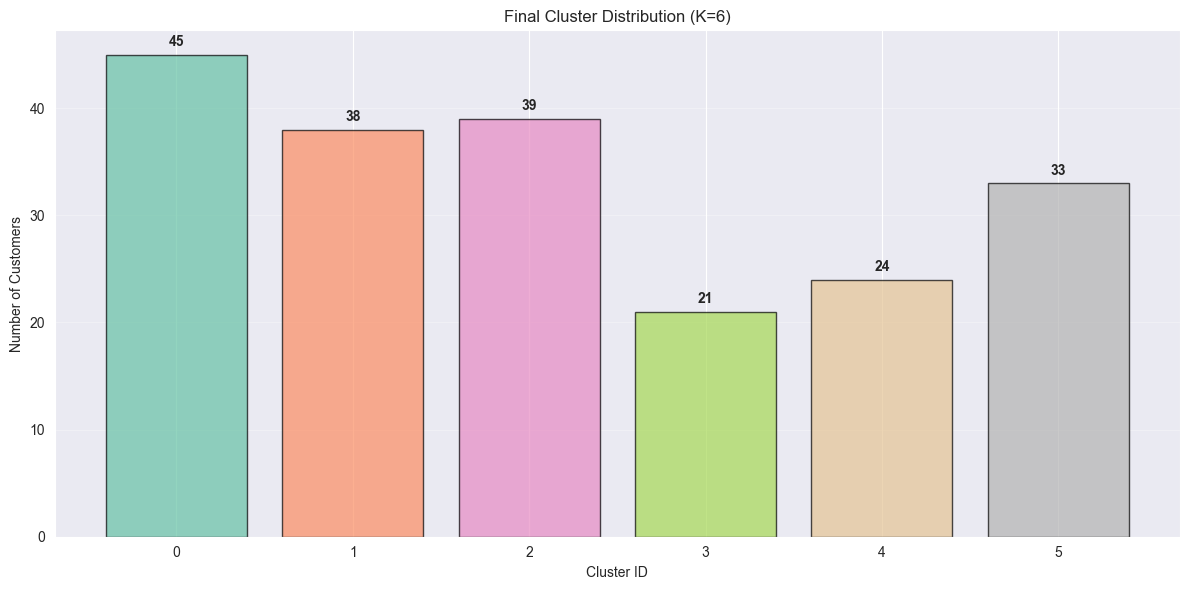

In [22]:
# --- Cluster Distribution ---
unique, counts = np.unique(final_cluster_labels, return_counts=True)
colors = plt.cm.Set2(np.linspace(0, 1, optimalK))

plt.figure(figsize=(12, 6))
bars = plt.bar(unique, counts, color=colors[:len(unique)], alpha=0.7, edgecolor='black')

# Add count labels on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.xlabel('Cluster ID')
plt.ylabel('Number of Customers')
plt.title(f'Final Cluster Distribution (K={optimalK})')
plt.xticks(unique)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


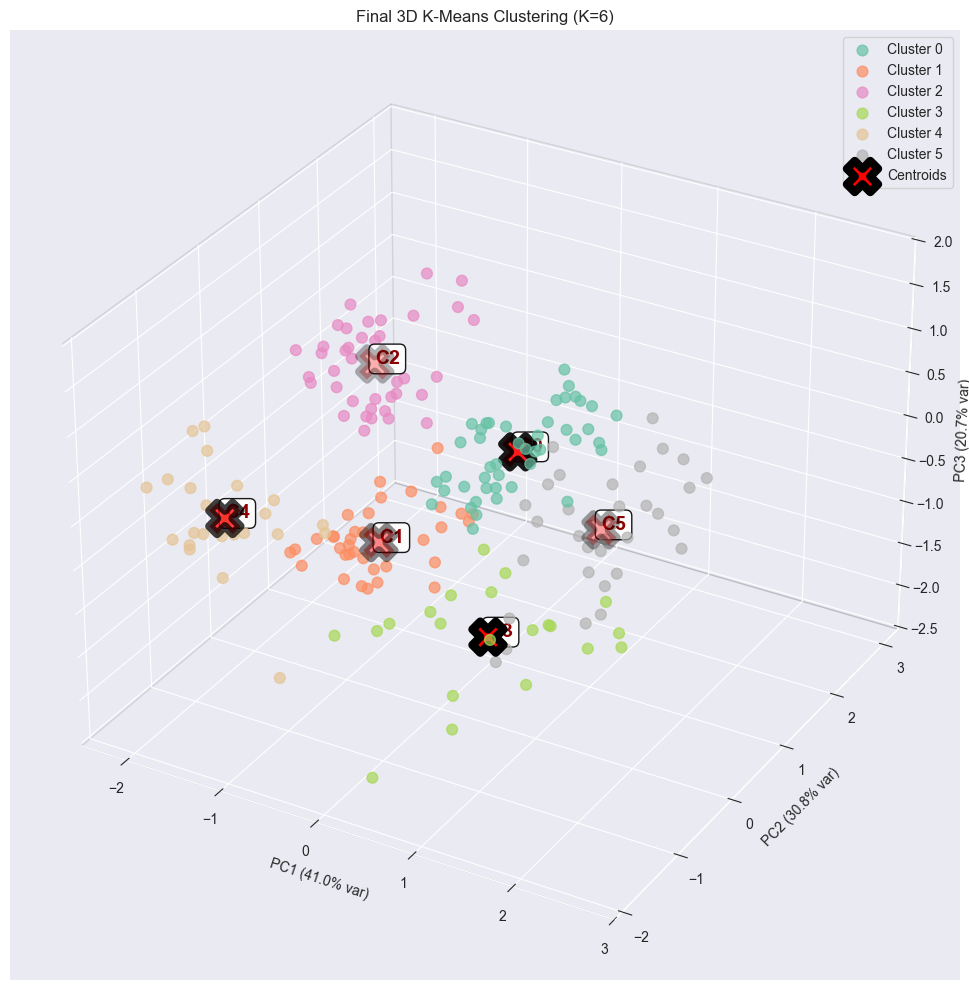

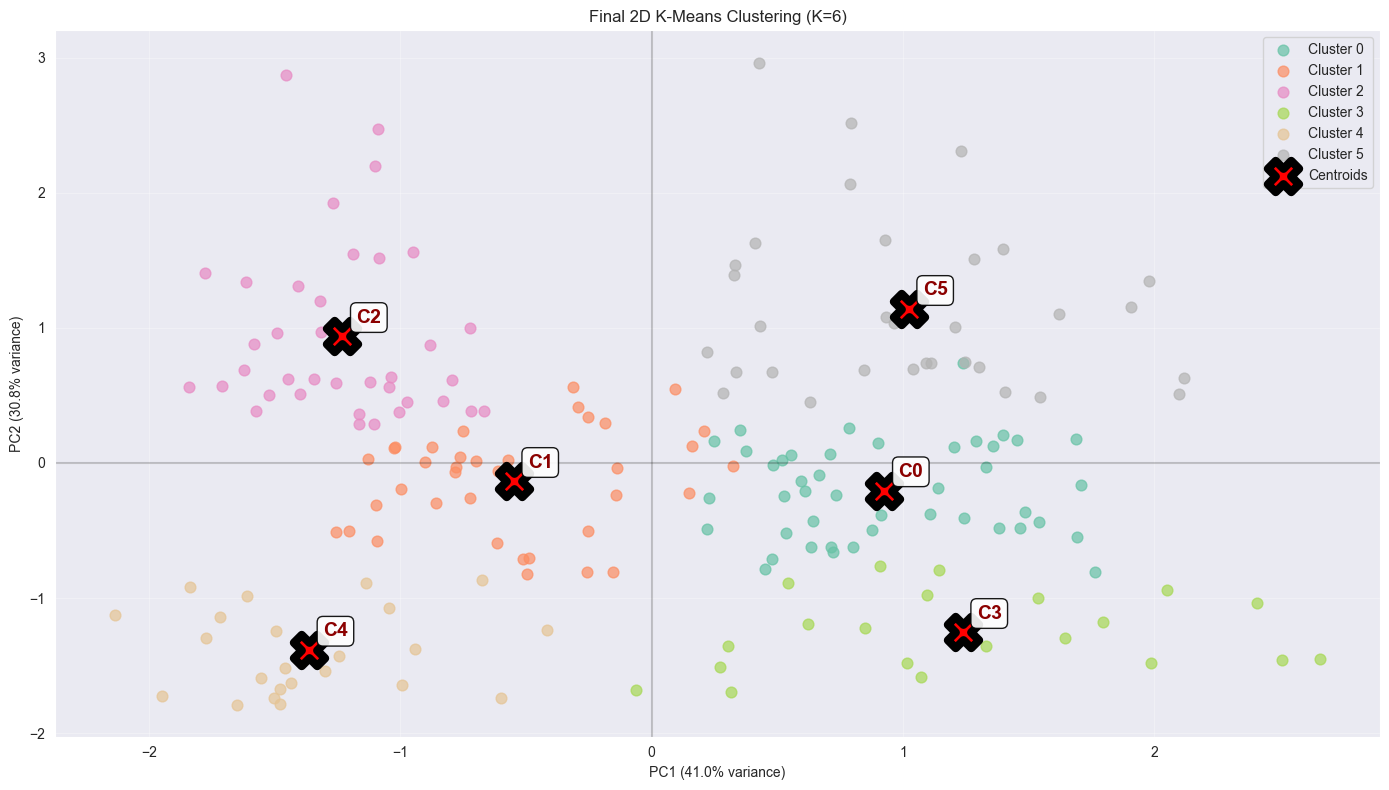

In [23]:
# --- Final Cluster Visualizations ---
# 3D Visualization
if best_n_components >= 3:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot data points colored by cluster
    for cluster_id in range(optimalK):
        cluster_mask = final_cluster_labels == cluster_id
        cluster_data = pca_df[cluster_mask]
        ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'],
                  c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
                  s=60, alpha=0.7)

    # Plot centroids as RED crosses with black border
    ax.scatter(final_centroids[:, 0], final_centroids[:, 1], final_centroids[:, 2],
              c='red', marker='X', s=500, linewidths=6,
              label='Centroids', edgecolors='black')

    # Add centroid labels
    for i, centroid in enumerate(final_centroids):
        ax.text(centroid[0], centroid[1], centroid[2], f'C{i}',
               fontsize=14, fontweight='bold', color='darkred',
               bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                        edgecolor='black', alpha=0.9))

    ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%} var)')
    ax.set_zlabel(f'PC3 ({explained_variance[2]:.1%} var)')
    ax.set_title(f'Final 3D K-Means Clustering (K={optimalK})')
    ax.legend()

    # Make axes more visible
    ax.grid(True, alpha=0.3)
    for pane in [ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane]:
        pane.set_edgecolor('black')
        pane.set_alpha(0.1)
        pane.fill = False

    plt.tight_layout()
    plt.show()

# 2D Visualization
plt.figure(figsize=(14, 8))

# Plot data points colored by cluster
for cluster_id in range(optimalK):
    cluster_mask = final_cluster_labels == cluster_id
    cluster_data = pca_df[cluster_mask]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'],
               c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
               s=60, alpha=0.7)

# Plot centroids as RED crosses with black border
plt.scatter(final_centroids[:, 0], final_centroids[:, 1],
           c='red', marker='X', s=500, linewidths=6,
           label='Centroids', edgecolors='black')

# Add centroid labels
for i, centroid in enumerate(final_centroids):
    plt.annotate(f'C{i}', (centroid[0], centroid[1]),
                xytext=(10, 10), textcoords='offset points',
                fontsize=14, fontweight='bold', color='darkred',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white',
                         edgecolor='black', alpha=0.9))

plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
plt.title(f'Final 2D K-Means Clustering (K={optimalK})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.2)
plt.tight_layout()
plt.show()


In [24]:
# --- Map Clusters Back to Original Features for Analysis ---
# Read original data again for analysis
original_df = pd.read_csv(file_path)
original_df.rename(columns={'Genre': 'Gender'}, inplace=True)
original_df.drop('CustomerID', axis=1, inplace=True)

# Add cluster labels to original data
analysis_df = original_df.copy()
analysis_df['Cluster'] = final_cluster_labels

print("Cluster Analysis based on Original Features:")
print("=" * 60)

# Calculate cluster statistics
cluster_summary = analysis_df.groupby('Cluster').agg({
    'Age': ['mean', 'std'],
    'Annual Income (k$)': ['mean', 'std'],
    'Spending Score (1-100)': ['mean', 'std'],
    'Gender': lambda x: (x == 'Female').sum() / len(x) * 100  # Percentage of females
}).round(2)

cluster_summary.columns = ['Age_Mean', 'Age_Std', 'Income_Mean', 'Income_Std',
                          'Spending_Mean', 'Spending_Std', 'Female_Percentage']

print(cluster_summary)


Cluster Analysis based on Original Features:
         Age_Mean  Age_Std  Income_Mean  Income_Std  Spending_Mean  \
Cluster                                                              
0           56.33     8.45        54.27        8.98          49.07   
1           26.68     7.12        57.58        9.85          47.79   
2           32.69     3.73        86.54       16.31          82.13   
3           45.52    11.77        26.29        7.44          19.38   
4           25.25     5.33        25.83        8.06          76.92   
5           41.94    10.18        88.94       16.59          16.97   

         Spending_Std  Female_Percentage  
Cluster                                   
0                6.30              57.78  
1                9.87              63.16  
2                9.36              53.85  
3               12.56              61.90  
4               13.42              58.33  
5                9.96              42.42  


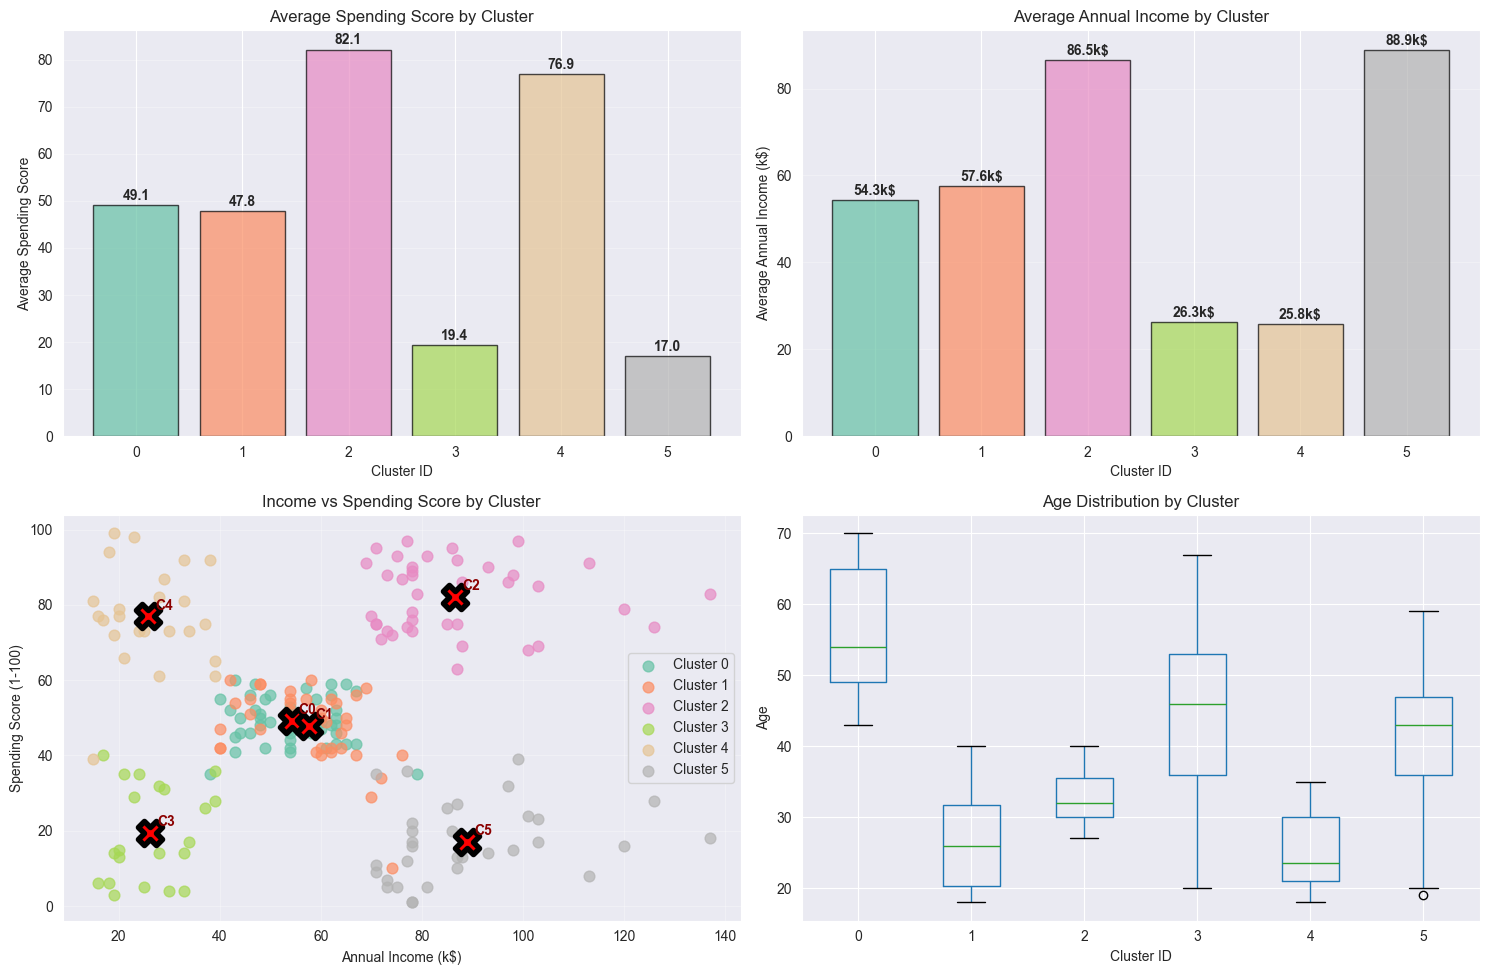

In [25]:
# --- Average Spending Analysis per Cluster ---
plt.figure(figsize=(15, 10))

# 1. Average Spending Score by Cluster
plt.subplot(2, 2, 1)
spending_means = analysis_df.groupby('Cluster')['Spending Score (1-100)'].mean()
bars = plt.bar(spending_means.index, spending_means.values,
               color=colors[:len(spending_means)], alpha=0.7, edgecolor='black')

for bar, value in zip(bars, spending_means.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Cluster ID')
plt.ylabel('Average Spending Score')
plt.title('Average Spending Score by Cluster')
plt.grid(True, alpha=0.3, axis='y')

# 2. Average Income by Cluster
plt.subplot(2, 2, 2)
income_means = analysis_df.groupby('Cluster')['Annual Income (k$)'].mean()
bars = plt.bar(income_means.index, income_means.values,
               color=colors[:len(income_means)], alpha=0.7, edgecolor='black')

for bar, value in zip(bars, income_means.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}k$', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Cluster ID')
plt.ylabel('Average Annual Income (k$)')
plt.title('Average Annual Income by Cluster')
plt.grid(True, alpha=0.3, axis='y')

# 3. Income vs Spending by Cluster
plt.subplot(2, 2, 3)
for cluster_id in range(optimalK):
    cluster_data = analysis_df[analysis_df['Cluster'] == cluster_id]
    plt.scatter(cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'],
               c=[colors[cluster_id]], label=f'Cluster {cluster_id}', s=60, alpha=0.7)

# Add cluster centers in original feature space
for cluster_id in range(optimalK):
    cluster_data = analysis_df[analysis_df['Cluster'] == cluster_id]
    center_income = cluster_data['Annual Income (k$)'].mean()
    center_spending = cluster_data['Spending Score (1-100)'].mean()
    plt.scatter(center_income, center_spending, c='red', marker='X', s=300,
               linewidths=4, edgecolors='black')
    plt.annotate(f'C{cluster_id}', (center_income, center_spending),
                xytext=(5, 5), textcoords='offset points',
                fontsize=10, fontweight='bold', color='darkred')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Income vs Spending Score by Cluster')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Age distribution by Cluster
plt.subplot(2, 2, 4)
analysis_df.boxplot(column='Age', by='Cluster', ax=plt.gca())
plt.title('Age Distribution by Cluster')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Cluster ID')
plt.ylabel('Age')

plt.tight_layout()
plt.show()


In [26]:
# --- Detailed Cluster Interpretation ---
print("\n" + "="*70)
print("DETAILED CLUSTER INTERPRETATION")
print("="*70)

for i in range(optimalK):
    cluster_data = cluster_summary.loc[i]
    cluster_size = (analysis_df['Cluster'] == i).sum()

    print(f"\nCluster {i} ({cluster_size} customers - {cluster_size/len(analysis_df)*100:.1f}%):")
    print("-" * 50)
    print(f"  • Demographics:")
    print(f"    - Average Age: {cluster_data['Age_Mean']:.1f} ± {cluster_data['Age_Std']:.1f} years")
    print(f"    - Gender Split: {cluster_data['Female_Percentage']:.1f}% Female, {100-cluster_data['Female_Percentage']:.1f}% Male")

    print(f"  • Financial Profile:")
    print(f"    - Average Income: {cluster_data['Income_Mean']:.1f}k$ ± {cluster_data['Income_Std']:.1f}")
    print(f"    - Average Spending Score: {cluster_data['Spending_Mean']:.1f} ± {cluster_data['Spending_Std']:.1f}")
    print(f"    - Spending vs Income Ratio: {cluster_data['Spending_Mean']/cluster_data['Income_Mean']:.2f}")

# Summary statistics
print(f"\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"Total Customers Segmented: {len(analysis_df)}")
print(f"Number of Clusters: {optimalK}")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Inertia: {final_inertia:.2f}")

# Spending insights
highest_spending_cluster = spending_means.idxmax()
lowest_spending_cluster = spending_means.idxmin()
print(f"\nSpending Insights:")
print(f"• Highest spending cluster: Cluster {highest_spending_cluster} (avg: {spending_means[highest_spending_cluster]:.1f})")
print(f"• Lowest spending cluster: Cluster {lowest_spending_cluster} (avg: {spending_means[lowest_spending_cluster]:.1f})")


DETAILED CLUSTER INTERPRETATION

Cluster 0 (45 customers - 22.5%):
--------------------------------------------------
  • Demographics:
    - Average Age: 56.3 ± 8.4 years
    - Gender Split: 57.8% Female, 42.2% Male
  • Financial Profile:
    - Average Income: 54.3k$ ± 9.0
    - Average Spending Score: 49.1 ± 6.3
    - Spending vs Income Ratio: 0.90

Cluster 1 (38 customers - 19.0%):
--------------------------------------------------
  • Demographics:
    - Average Age: 26.7 ± 7.1 years
    - Gender Split: 63.2% Female, 36.8% Male
  • Financial Profile:
    - Average Income: 57.6k$ ± 9.8
    - Average Spending Score: 47.8 ± 9.9
    - Spending vs Income Ratio: 0.83

Cluster 2 (39 customers - 19.5%):
--------------------------------------------------
  • Demographics:
    - Average Age: 32.7 ± 3.7 years
    - Gender Split: 53.9% Female, 46.1% Male
  • Financial Profile:
    - Average Income: 86.5k$ ± 16.3
    - Average Spending Score: 82.1 ± 9.4
    - Spending vs Income Ratio: 0.95

Cl

#### 📝 Customer Segmentation Report

##### Cluster 0 – **🟠 Mature Steady Spenders (22.5%)**

* **Profile:** Mid-income, Moderate spending , Oldest group.
* **Insight:** Loyal and predictable, value stability over novelty.
* **Strategy:** Classic product lines, trust-building marketing, loyalty benefits.

---

##### Cluster 1 – **🟠 Young Professionals (19.0%)**

* **Profile:** Mid-income, Moderate spending , Young adults.
* **Insight:** Growth potential, just starting to form brand loyalties.
* **Strategy:** Trendy products, lifestyle branding, upsell to premium tiers.

---

##### Cluster 2 – **🟢 Premium Customers (19.5%)**

* **Profile:** High income, High spending, relatively young adults.
* **Insight:** Core high-value segment.
* **Strategy:** Luxury & exclusive experiences, VIP memberships, personal services.

---

##### Cluster 3 – **🔴 Budget-Conscious Adults (10.5%)**

* **Profile:** Low income, Low spending, Middle-aged.
* **Insight:** Price-sensitive, careful with purchases.
* **Strategy:** Discounts, affordable bundles, essential product lines.

---

##### Cluster 4 – **🟡 Impulsive Young Shoppers (12.0%)**

* **Profile:** Low income, Very high spending ,Youngest group.
* **Insight:** Over-index on lifestyle purchases, risk of overspending.
* **Strategy:** Flexible payment options, loyalty rewards, social media-driven campaigns.

---

##### Cluster 5 – **🔵 Conservative Affluent Adults (16.5%)**

* **Profile:** High income, Low spending, older adults.
* **Insight:** Untapped wealth, careful decision-makers.
* **Strategy:** Value-based marketing, highlight exclusivity, limited-time offers.

---

##### 📊 Overall Marketing Insights

* **Cluster 2 (Premium Customers)**: Core profit drivers → protect and pamper.
* **Cluster 5 (Conservative Affluent)**: Unlock hidden potential with exclusivity-based nudges.
* **Cluster 4 (Impulsive Young)**: Keep engaged with lifestyle-driven campaigns + flexible payments.
* **Cluster 3 (Budget-Conscious Adults)**: Retain with affordable essentials.
* **Cluster 0 & 1 (Average Customers)**: Long-term customer base → build brand trust early and maintain loyalty.

### BONUS : DBSCAN Clustering

Finding optimal epsilon using K-distance plot...


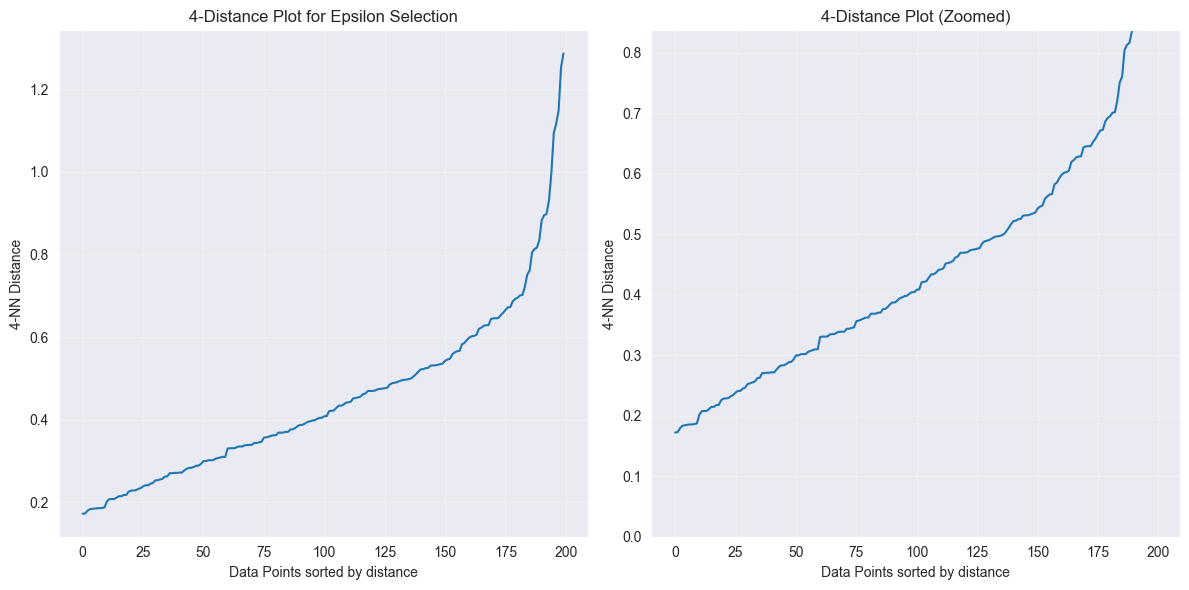

Suggested epsilon range: 0.554 - 0.831


In [27]:
# Remove the Cluster column from pca_df for DBSCAN
pca_features = pca_df.drop('Cluster', axis=1)

# --- 1. Find Optimal Epsilon using K-distance plot ---
print("Finding optimal epsilon using K-distance plot...")

# Calculate distances to k-th nearest neighbor (typically k=4 for DBSCAN)
k = 4
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(pca_features)
distances, indices = neigh.kneighbors(pca_features)

# Sort the distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot K-distance graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}-NN Distance')
plt.title(f'{k}-Distance Plot for Epsilon Selection')
plt.grid(True, alpha=0.3)

# Zoom in on the elbow region
plt.subplot(1, 2, 2)
plt.plot(distances)
plt.xlabel('Data Points sorted by distance')
plt.ylabel(f'{k}-NN Distance')
plt.title(f'{k}-Distance Plot (Zoomed)')
plt.grid(True, alpha=0.3)
# Focus on the potential elbow region
plt.ylim(0, np.percentile(distances, 95))

plt.tight_layout()
plt.show()

# Suggest epsilon values based on the plot
knee_point = np.percentile(distances, 90)  # Often around 90th percentile
print(f"Suggested epsilon range: {knee_point*0.8:.3f} - {knee_point*1.2:.3f}")


In [28]:
# --- 2. Test different epsilon and min_samples values ---
epsilon_values = np.arange(0.5, 0.9, 0.001)
min_samples_values = [3, 4, 5, 6]

dbscan_results = []

print("Testing different DBSCAN parameters...")
print("Epsilon\tMin_Samples\tClusters\tNoise_Points\tSilhouette")
print("-" * 60)

for eps in epsilon_values:
    for min_samp in min_samples_values:
        # Fit DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samp)
        cluster_labels = dbscan.fit_predict(pca_features)

        # Calculate metrics
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        # Calculate silhouette score (only if we have more than 1 cluster and not all noise)
        if n_clusters > 1 and n_noise < len(cluster_labels):
            sil_score = silhouette_score(pca_features, cluster_labels)
        else:
            sil_score = -1

        # Store results
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samp,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score,
            'labels': cluster_labels
        })

        print(f"{eps:.3f}\t{min_samp}\t\t{n_clusters}\t\t{n_noise}\t\t{sil_score:.3f}")


Testing different DBSCAN parameters...
Epsilon	Min_Samples	Clusters	Noise_Points	Silhouette
------------------------------------------------------------
0.500	3		9		29		0.139
0.500	4		8		37		0.123
0.500	5		6		58		0.192
0.500	6		5		66		0.219
0.501	3		9		29		0.139
0.501	4		8		37		0.123
0.501	5		6		58		0.192
0.501	6		5		66		0.219
0.502	3		9		29		0.139
0.502	4		8		37		0.123
0.502	5		6		58		0.192
0.502	6		5		66		0.219
0.503	3		9		27		0.147
0.503	4		8		36		0.127
0.503	5		6		56		0.200
0.503	6		5		66		0.219
0.504	3		9		27		0.147
0.504	4		8		36		0.127
0.504	5		6		56		0.200
0.504	6		5		66		0.219
0.505	3		9		27		0.147
0.505	4		8		36		0.127
0.505	5		6		56		0.200
0.505	6		5		66		0.219
0.506	3		9		27		0.147
0.506	4		8		36		0.127
0.506	5		6		56		0.200
0.506	6		5		66		0.219
0.507	3		9		27		0.147
0.507	4		8		36		0.127
0.507	5		6		56		0.200
0.507	6		5		66		0.219
0.508	3		9		27		0.147
0.508	4		8		36		0.127
0.508	5		6		56		0.200
0.508	6		5		66		0.219
0.509	3		8		27		0.061
0.509	4		7		36		0.041
0.509	5		5	

In [29]:
# --- 3. Find best parameters ---
# Filter valid results (more than 1 cluster, reasonable noise ratio)
valid_results = [r for r in dbscan_results if r['n_clusters'] > 1 and r['n_noise'] < len(pca_features) * 0.5]

if valid_results:
    # Find best result based on silhouette score
    best_result = max(valid_results, key=lambda x: x['silhouette'])

    print(f"\nBest DBSCAN parameters:")
    print(f"Epsilon: {best_result['eps']}")
    print(f"Min Samples: {best_result['min_samples']}")
    print(f"Number of Clusters: {best_result['n_clusters']}")
    print(f"Noise Points: {best_result['n_noise']}")
    print(f"Silhouette Score: {best_result['silhouette']:.4f}")

    # Apply best DBSCAN
    best_eps = best_result['eps']
    best_min_samples = best_result['min_samples']
    dbscan_labels = best_result['labels']

else:
    print("No valid DBSCAN results found. Using default parameters.")
    best_eps = 0.5
    best_min_samples = 4
    dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    dbscan_labels = dbscan.fit_predict(pca_features)



Best DBSCAN parameters:
Epsilon: 0.559
Min Samples: 6
Number of Clusters: 5
Noise Points: 56
Silhouette Score: 0.2485


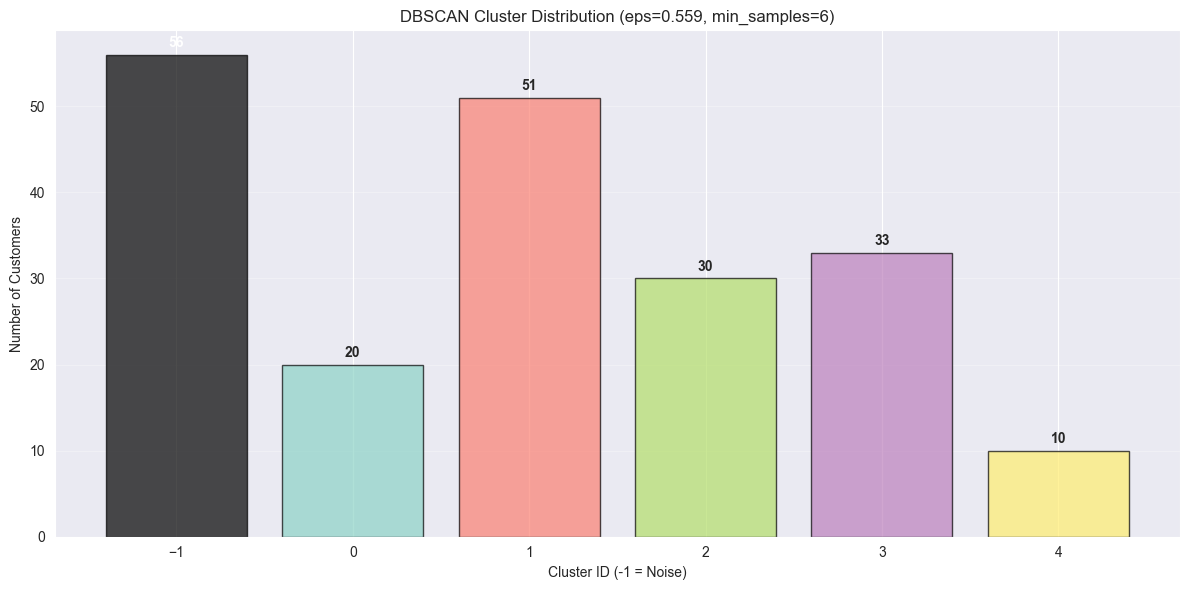

In [30]:
# --- 4. Visualize DBSCAN Results ---
# Get unique clusters (excluding noise points)
unique_clusters = set(dbscan_labels)
if -1 in unique_clusters:
    unique_clusters.remove(-1)
n_clusters_dbscan = len(unique_clusters)

# Create colors for clusters (noise points will be black)
colors_dbscan = plt.cm.Set3(np.linspace(0, 1, n_clusters_dbscan))
color_map = {}
for i, cluster_id in enumerate(sorted(unique_clusters)):
    color_map[cluster_id] = colors_dbscan[i]
color_map[-1] = 'black'  # Noise points in black

# Cluster distribution histogram
plt.figure(figsize=(12, 6))
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)

# Separate cluster bars and noise bar
cluster_indices = [i for i, label in enumerate(unique_labels) if label != -1]
noise_index = [i for i, label in enumerate(unique_labels) if label == -1]

if cluster_indices:
    cluster_labels_hist = unique_labels[cluster_indices]
    cluster_counts = counts[cluster_indices]
    cluster_colors = [color_map[label] for label in cluster_labels_hist]

    bars = plt.bar(cluster_labels_hist, cluster_counts, color=cluster_colors, alpha=0.7, edgecolor='black')

    # Add count labels
    for bar, count in zip(bars, cluster_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontweight='bold')

# Add noise bar if exists
if noise_index:
    noise_count = counts[noise_index[0]]
    noise_bar = plt.bar(-1, noise_count, color='black', alpha=0.7, edgecolor='black')
    plt.text(-1, noise_count + 0.5, str(noise_count), ha='center', va='bottom', fontweight='bold', color='white')

plt.xlabel('Cluster ID (-1 = Noise)')
plt.ylabel('Number of Customers')
plt.title(f'DBSCAN Cluster Distribution (eps={best_eps}, min_samples={best_min_samples})')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


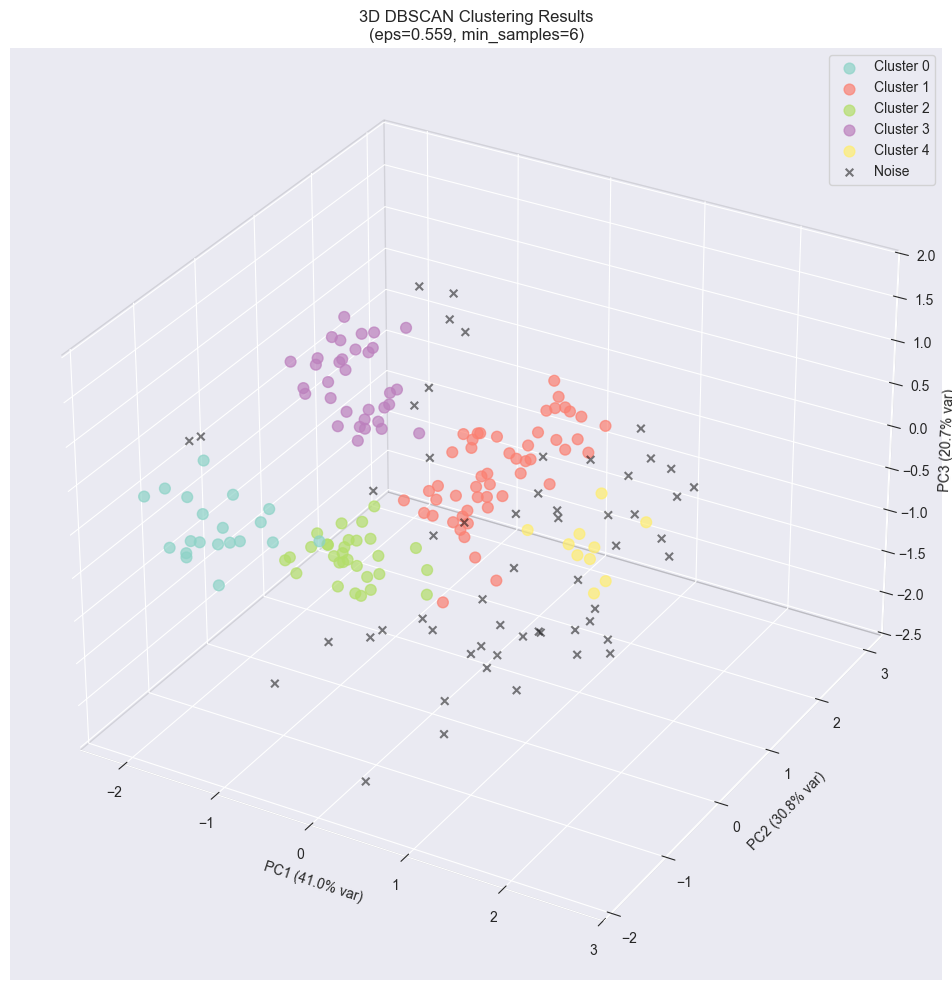

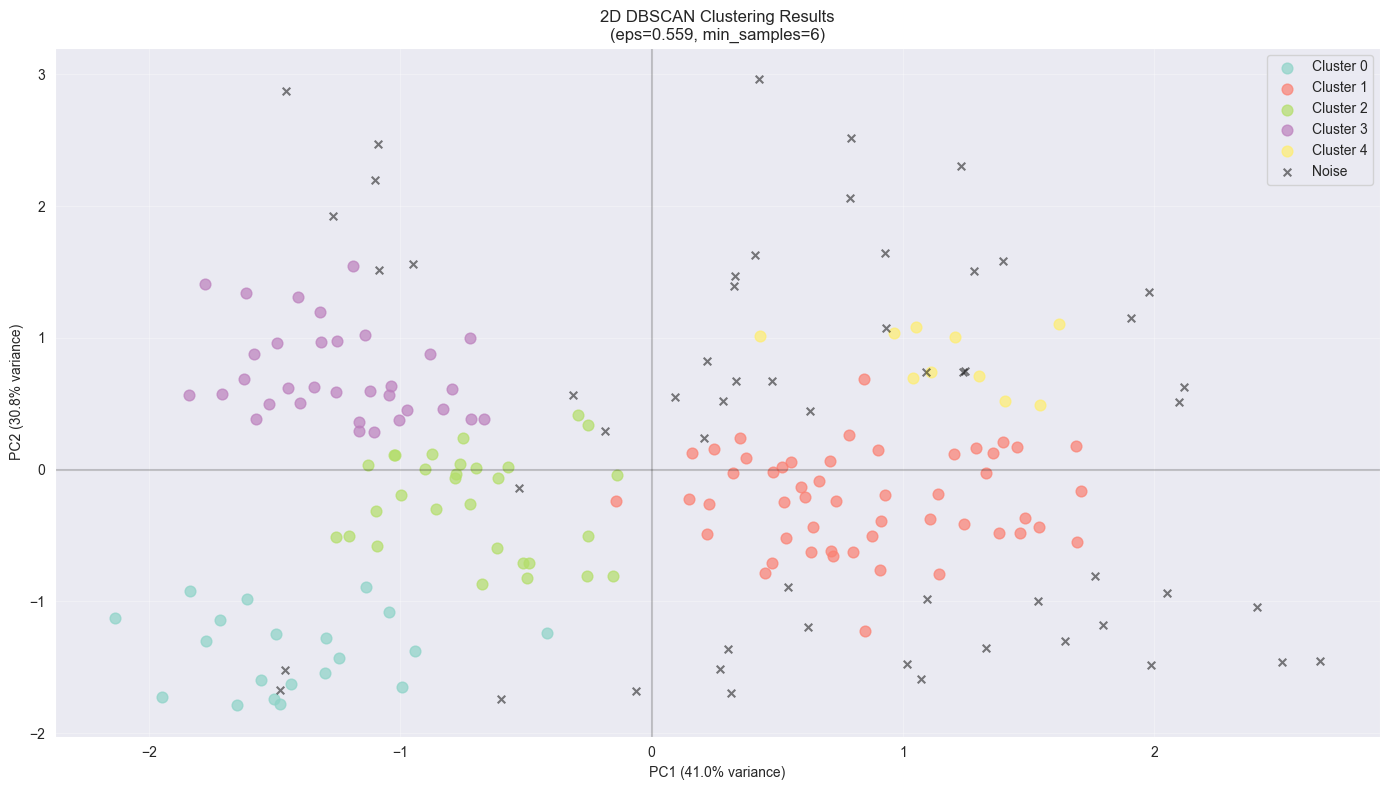

In [31]:
# --- 5. 3D and 2D Visualizations ---
# 3D Visualization (if available)
if best_n_components >= 3:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cluster
    for cluster_id in unique_clusters:
        cluster_mask = dbscan_labels == cluster_id
        cluster_data = pca_features[cluster_mask]
        ax.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1], cluster_data.iloc[:, 2],
                  c=[color_map[cluster_id]], label=f'Cluster {cluster_id}', s=60, alpha=0.7)

    # Plot noise points
    if -1 in dbscan_labels:
        noise_mask = dbscan_labels == -1
        noise_data = pca_features[noise_mask]
        ax.scatter(noise_data.iloc[:, 0], noise_data.iloc[:, 1], noise_data.iloc[:, 2],
                  c='black', label='Noise', s=30, alpha=0.5, marker='x')

    ax.set_xlabel(f'PC1 ({explained_variance[0]:.1%} var)')
    ax.set_ylabel(f'PC2 ({explained_variance[1]:.1%} var)')
    ax.set_zlabel(f'PC3 ({explained_variance[2]:.1%} var)')
    ax.set_title(f'3D DBSCAN Clustering Results\n(eps={best_eps}, min_samples={best_min_samples})')
    ax.legend()

    # Make axes more visible
    ax.grid(True, alpha=0.3)
    for pane in [ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane]:
        pane.set_edgecolor('black')
        pane.set_alpha(0.1)
        pane.fill = False

    plt.tight_layout()
    plt.show()

# 2D Visualization
plt.figure(figsize=(14, 8))

# Plot each cluster
for cluster_id in unique_clusters:
    cluster_mask = dbscan_labels == cluster_id
    cluster_data = pca_features[cluster_mask]
    plt.scatter(cluster_data.iloc[:, 0], cluster_data.iloc[:, 1],
               c=[color_map[cluster_id]], label=f'Cluster {cluster_id}', s=60, alpha=0.7)

# Plot noise points
if -1 in dbscan_labels:
    noise_mask = dbscan_labels == -1
    noise_data = pca_features[noise_mask]
    plt.scatter(noise_data.iloc[:, 0], noise_data.iloc[:, 1],
               c='black', label='Noise', s=30, alpha=0.5, marker='x')

plt.xlabel(f'PC1 ({explained_variance[0]:.1%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.1%} variance)')
plt.title(f'2D DBSCAN Clustering Results\n(eps={best_eps}, min_samples={best_min_samples})')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.2)
plt.tight_layout()
plt.show()


In [32]:
# --- 6. DBSCAN Analysis with Original Features ---
# Add DBSCAN labels to analysis dataframe
analysis_df_dbscan = original_df.copy()
analysis_df_dbscan['DBSCAN_Cluster'] = dbscan_labels

# Separate noise points for analysis
cluster_data = analysis_df_dbscan[analysis_df_dbscan['DBSCAN_Cluster'] != -1]
noise_data = analysis_df_dbscan[analysis_df_dbscan['DBSCAN_Cluster'] == -1]

print("DBSCAN Cluster Analysis based on Original Features:")
print("=" * 60)

if len(cluster_data) > 0:
    # Calculate cluster statistics (excluding noise)
    dbscan_summary = cluster_data.groupby('DBSCAN_Cluster').agg({
        'Age': ['mean', 'std'],
        'Annual Income (k$)': ['mean', 'std'],
        'Spending Score (1-100)': ['mean', 'std'],
        'Gender': lambda x: (x == 'Female').sum() / len(x) * 100
    }).round(2)

    dbscan_summary.columns = ['Age_Mean', 'Age_Std', 'Income_Mean', 'Income_Std',
                             'Spending_Mean', 'Spending_Std', 'Female_Percentage']

    print(dbscan_summary)

    # Noise analysis
    if len(noise_data) > 0:
        print(f"\nNoise Points Analysis ({len(noise_data)} customers):")
        print(f"Average Age: {noise_data['Age'].mean():.1f}")
        print(f"Average Income: {noise_data['Annual Income (k$)'].mean():.1f}k$")
        print(f"Average Spending: {noise_data['Spending Score (1-100)'].mean():.1f}")
        print(f"Female Percentage: {(noise_data['Gender'] == 'Female').sum() / len(noise_data) * 100:.1f}%")


DBSCAN Cluster Analysis based on Original Features:
                Age_Mean  Age_Std  Income_Mean  Income_Std  Spending_Mean  \
DBSCAN_Cluster                                                              
0                  24.30     4.43        26.20        7.76          77.45   
1                  54.12     9.32        53.73        9.44          48.14   
2                  24.33     4.90        55.03        9.89          49.47   
3                  32.73     3.81        81.06        9.22          83.00   
4                  44.50     4.72        81.10        6.26          16.80   

                Spending_Std  Female_Percentage  
DBSCAN_Cluster                                   
0                       8.92              55.00  
1                       7.14              54.90  
2                       7.76              63.33  
3                       9.32              54.55  
4                       6.63              50.00  

Noise Points Analysis (56 customers):
Average Age: 40.5
A

## Step 6: K-Means vs DBSCAN Comparison

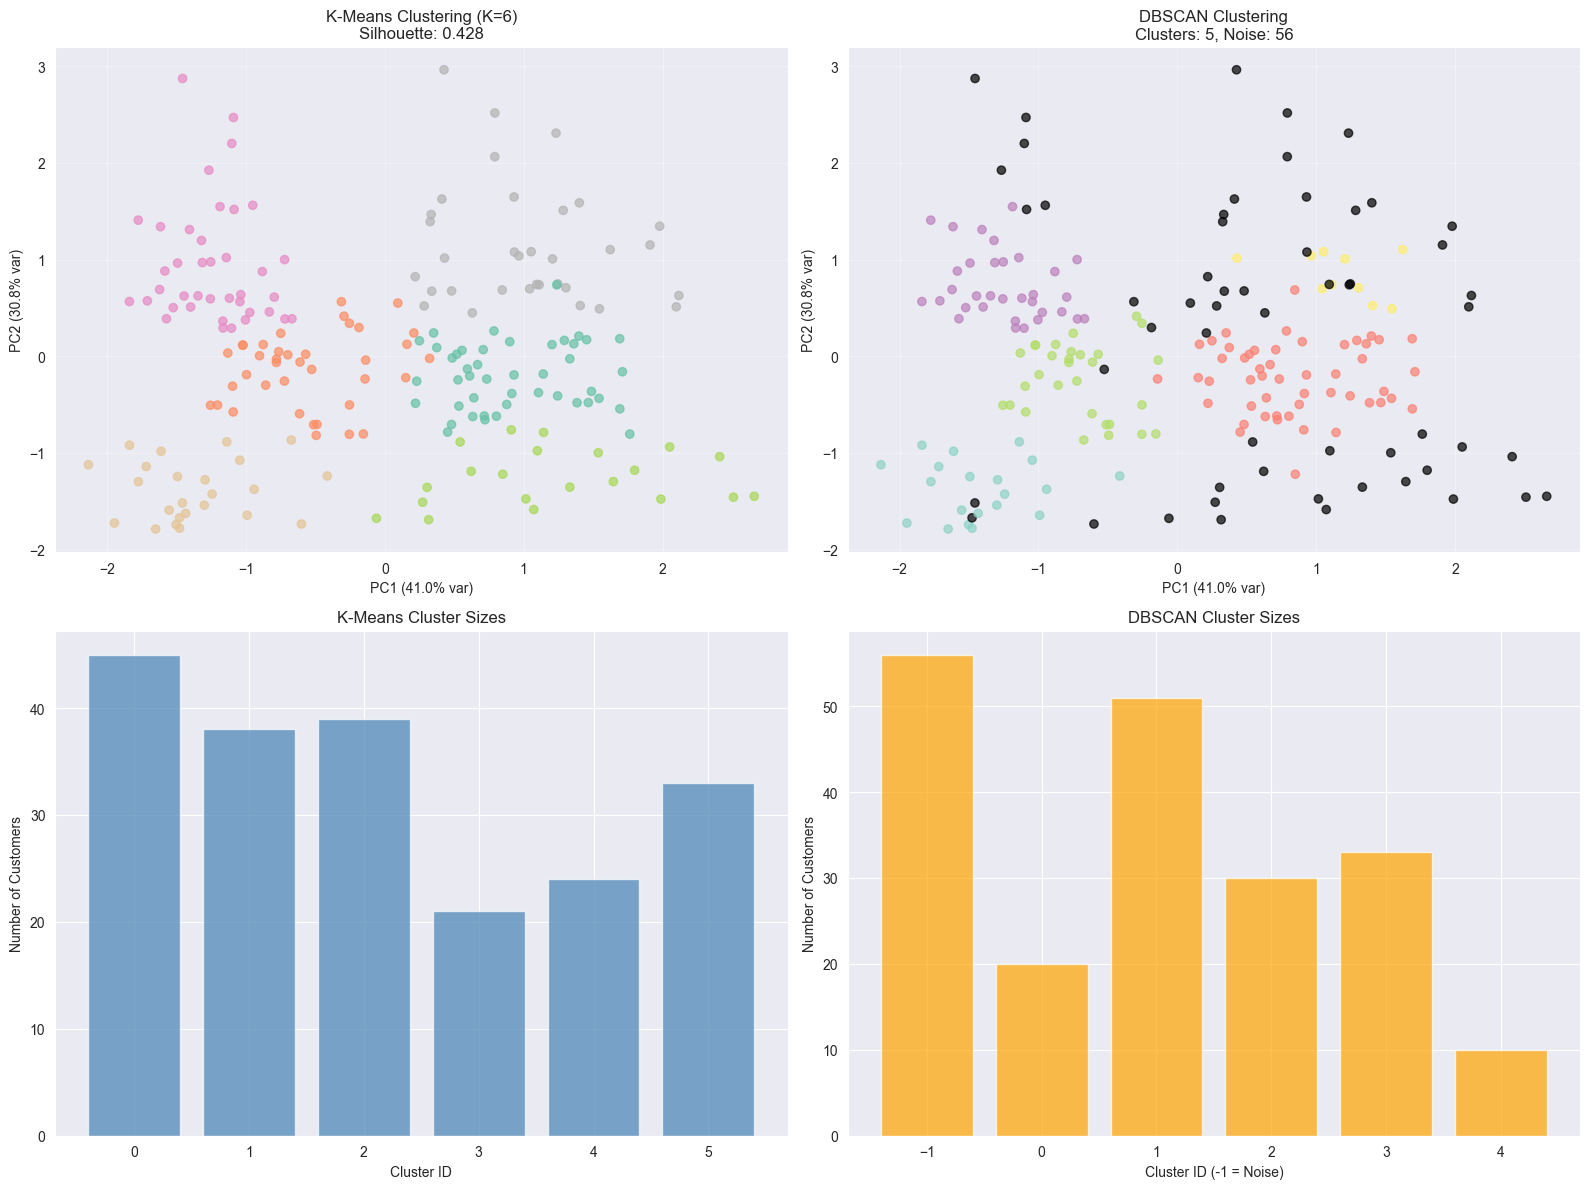


K-MEANS vs DBSCAN COMPARISON
K-Means:
  • Number of clusters: 6
  • Silhouette score: 0.4275
  • All points assigned to clusters

DBSCAN:
  • Number of clusters: 5
  • Noise points: 56 (28.0%)
  • Silhouette score: 0.2485
  • Best parameters: eps=0.559, min_samples=6

🏆 K-Means performs better in terms of silhouette score!


In [33]:
comparison_fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# K-Means results (using final results from earlier)
axes[0, 0].scatter(pca_features.iloc[:, 0], pca_features.iloc[:, 1],
                   c=final_cluster_labels, cmap='Set2', alpha=0.7)
axes[0, 0].set_title(f'K-Means Clustering (K={optimalK})\nSilhouette: {final_silhouette:.3f}')
axes[0, 0].set_xlabel(f'PC1 ({explained_variance[0]:.1%} var)')
axes[0, 0].set_ylabel(f'PC2 ({explained_variance[1]:.1%} var)')
axes[0, 0].grid(True, alpha=0.3)

# DBSCAN results
scatter_colors = [color_map[label] for label in dbscan_labels]
axes[0, 1].scatter(pca_features.iloc[:, 0], pca_features.iloc[:, 1],
                   c=scatter_colors, alpha=0.7)
axes[0, 1].set_title(f'DBSCAN Clustering\nClusters: {n_clusters_dbscan}, Noise: {list(dbscan_labels).count(-1)}')
axes[0, 1].set_xlabel(f'PC1 ({explained_variance[0]:.1%} var)')
axes[0, 1].set_ylabel(f'PC2 ({explained_variance[1]:.1%} var)')
axes[0, 1].grid(True, alpha=0.3)

# Cluster size comparison
kmeans_counts = pd.Series(final_cluster_labels).value_counts().sort_index()
dbscan_counts = pd.Series(dbscan_labels).value_counts().sort_index()

axes[1, 0].bar(kmeans_counts.index, kmeans_counts.values, alpha=0.7, color='steelblue')
axes[1, 0].set_title('K-Means Cluster Sizes')
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Number of Customers')

axes[1, 1].bar(dbscan_counts.index, dbscan_counts.values, alpha=0.7, color='orange')
axes[1, 1].set_title('DBSCAN Cluster Sizes')
axes[1, 1].set_xlabel('Cluster ID (-1 = Noise)')
axes[1, 1].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

# Summary comparison
print(f"\n" + "="*70)
print("K-MEANS vs DBSCAN COMPARISON")
print("="*70)
print(f"K-Means:")
print(f"  • Number of clusters: {optimalK}")
print(f"  • Silhouette score: {final_silhouette:.4f}")
print(f"  • All points assigned to clusters")

if valid_results:
    dbscan_silhouette = best_result['silhouette']
    print(f"\nDBSCAN:")
    print(f"  • Number of clusters: {n_clusters_dbscan}")
    print(f"  • Noise points: {list(dbscan_labels).count(-1)} ({list(dbscan_labels).count(-1)/len(dbscan_labels)*100:.1f}%)")
    print(f"  • Silhouette score: {dbscan_silhouette:.4f}")
    print(f"  • Best parameters: eps={best_eps}, min_samples={best_min_samples}")

    if dbscan_silhouette > final_silhouette:
        print(f"\n🏆 DBSCAN performs better in terms of silhouette score!")
    else:
        print(f"\n🏆 K-Means performs better in terms of silhouette score!")
else:
    print(f"\nDBSCAN: No valid clustering found with tested parameters")


## BONUS: Analyze average spending per cluster.

In [34]:
# --- Comprehensive Spending Analysis per K-Means Cluster ---
print("DETAILED SPENDING ANALYSIS PER K-MEANS CLUSTER")
print("=" * 70)

# Calculate detailed spending statistics per cluster
spending_analysis = analysis_df.groupby('Cluster')['Spending Score (1-100)'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

# Add percentiles for better understanding
spending_analysis['25th_percentile'] = analysis_df.groupby('Cluster')['Spending Score (1-100)'].quantile(0.25).round(2)
spending_analysis['75th_percentile'] = analysis_df.groupby('Cluster')['Spending Score (1-100)'].quantile(0.75).round(2)

# Calculate spending range and coefficient of variation
spending_analysis['range'] = spending_analysis['max'] - spending_analysis['min']
spending_analysis['cv'] = (spending_analysis['std'] / spending_analysis['mean'] * 100).round(2)

print("\nSpending Statistics by Cluster:")
print(spending_analysis)


DETAILED SPENDING ANALYSIS PER K-MEANS CLUSTER

Spending Statistics by Cluster:
         count   mean  median    std  min  max  25th_percentile  \
Cluster                                                           
0           45  49.07    49.0   6.30   35   60            45.00   
1           38  47.79    49.5   9.87   10   60            42.00   
2           39  82.13    83.0   9.36   63   97            74.50   
3           21  19.38    15.0  12.56    3   40             6.00   
4           24  76.92    76.5  13.42   39   99            72.75   
5           33  16.97    16.0   9.96    1   39            10.00   

         75th_percentile  range     cv  
Cluster                                 
0                  55.00     25  12.84  
1                  55.00     50  20.65  
2                  90.00     34  11.40  
3                  31.00     37  64.81  
4                  83.25     60  17.45  
5                  23.00     38  58.69  


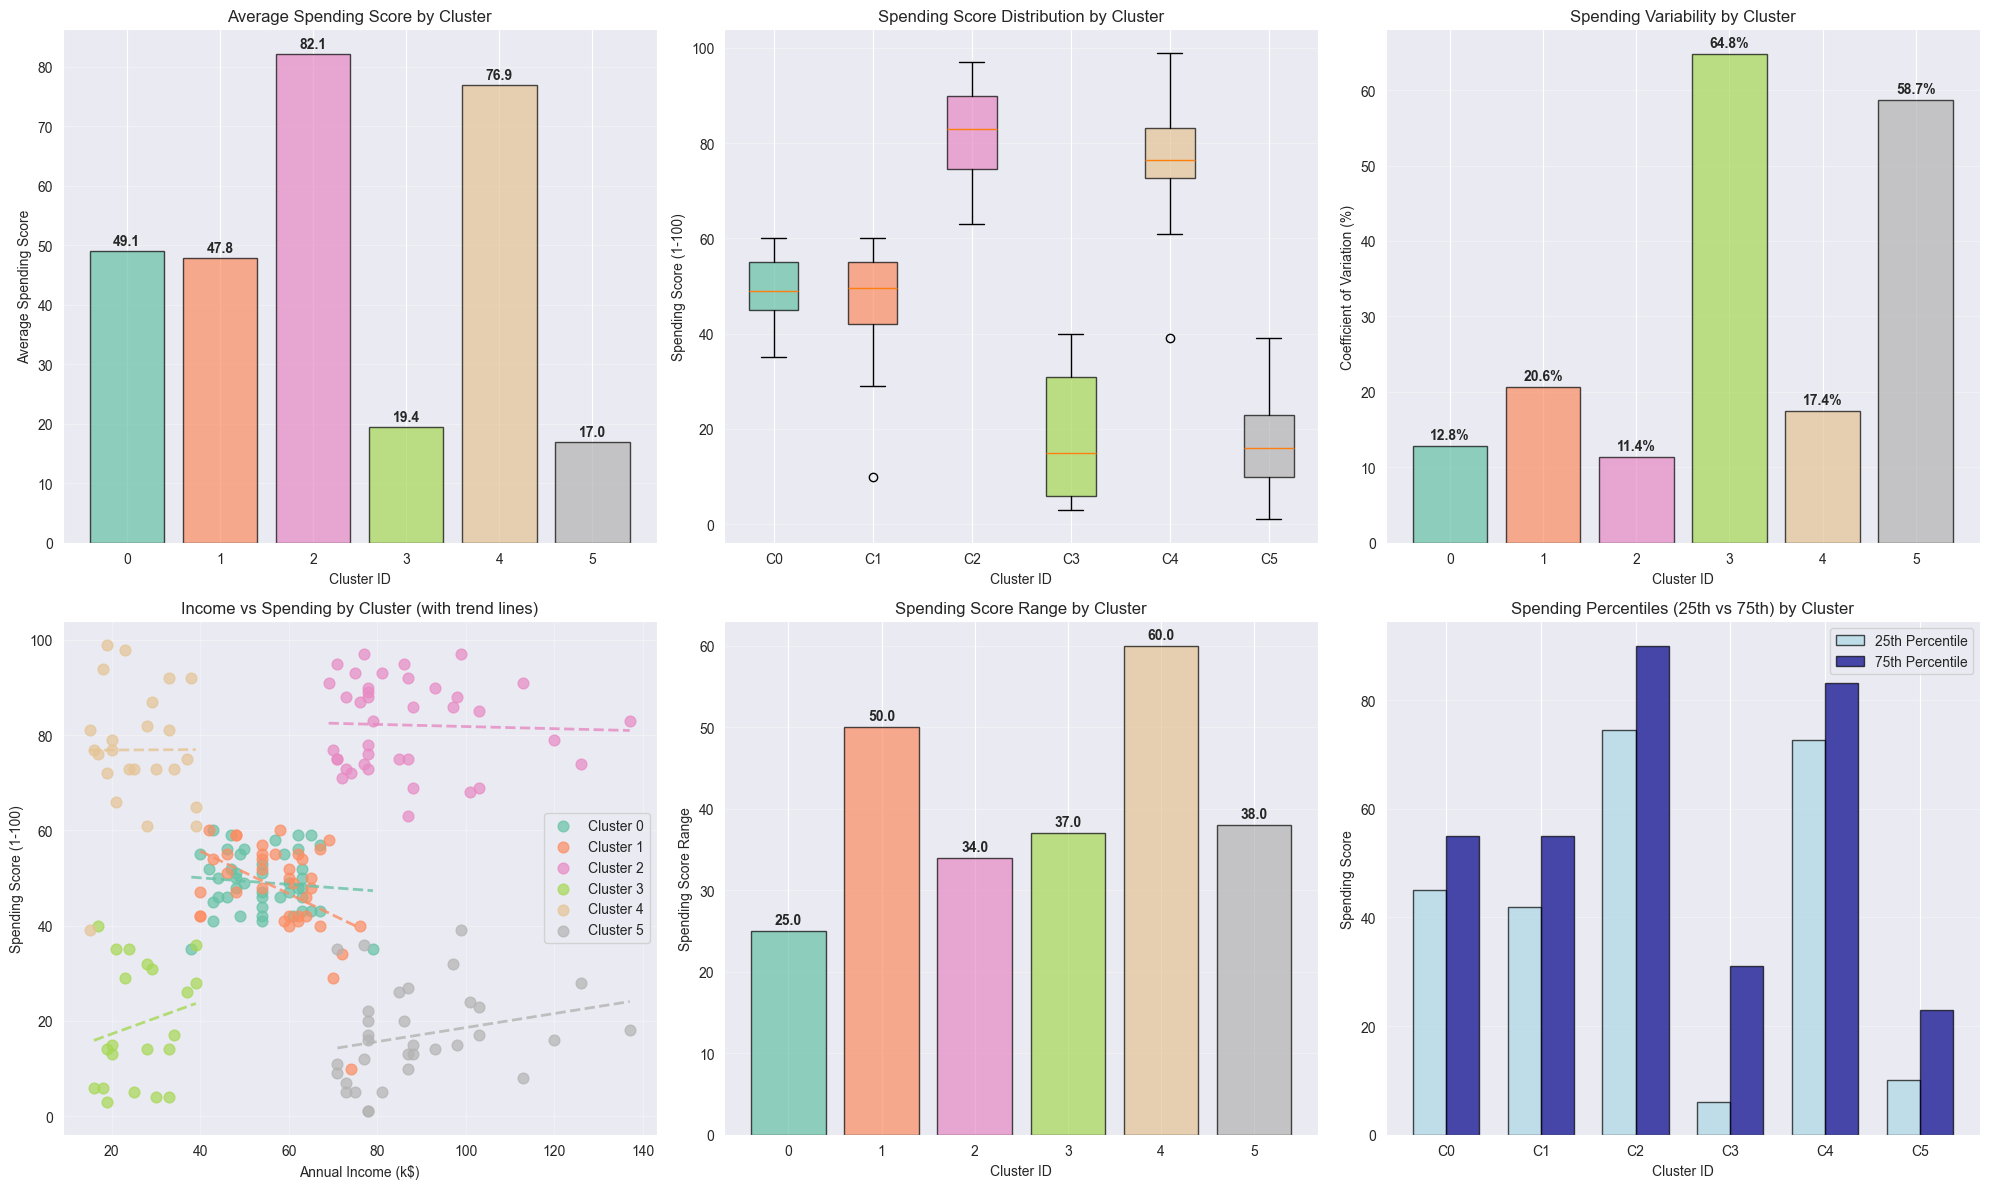

In [35]:
# --- Visual Analysis of Spending Patterns ---
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Average Spending by Cluster (Bar Chart)
ax1 = axes[0, 0]
bars = ax1.bar(spending_analysis.index, spending_analysis['mean'],
               color=colors[:len(spending_analysis)], alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar, value in zip(bars, spending_analysis['mean']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.set_xlabel('Cluster ID')
ax1.set_ylabel('Average Spending Score')
ax1.set_title('Average Spending Score by Cluster')
ax1.grid(True, alpha=0.3, axis='y')

# 2. Spending Distribution (Box Plot)
ax2 = axes[0, 1]
cluster_spending_data = [analysis_df[analysis_df['Cluster'] == i]['Spending Score (1-100)']
                        for i in range(optimalK)]
box_plot = ax2.boxplot(cluster_spending_data, tick_labels=[f'C{i}' for i in range(optimalK)], patch_artist=True)

# Color the boxes
for patch, color in zip(box_plot['boxes'], colors[:optimalK]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_xlabel('Cluster ID')
ax2.set_ylabel('Spending Score (1-100)')
ax2.set_title('Spending Score Distribution by Cluster')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Spending Variability (Coefficient of Variation)
ax3 = axes[0, 2]
bars = ax3.bar(spending_analysis.index, spending_analysis['cv'],
               color=colors[:len(spending_analysis)], alpha=0.7, edgecolor='black')

for bar, value in zip(bars, spending_analysis['cv']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax3.set_xlabel('Cluster ID')
ax3.set_ylabel('Coefficient of Variation (%)')
ax3.set_title('Spending Variability by Cluster')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Spending vs Income Relationship by Cluster
ax4 = axes[1, 0]
for cluster_id in range(optimalK):
    cluster_data = analysis_df[analysis_df['Cluster'] == cluster_id]
    ax4.scatter(cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'],
               c=[colors[cluster_id]], label=f'Cluster {cluster_id}', s=60, alpha=0.7)

# Add trend lines for each cluster
for cluster_id in range(optimalK):
    cluster_data = analysis_df[analysis_df['Cluster'] == cluster_id]
    z = np.polyfit(cluster_data['Annual Income (k$)'], cluster_data['Spending Score (1-100)'], 1)
    p = np.poly1d(z)
    ax4.plot(cluster_data['Annual Income (k$)'].sort_values(),
             p(cluster_data['Annual Income (k$)'].sort_values()),
             color=colors[cluster_id], linestyle='--', alpha=0.8, linewidth=2)

ax4.set_xlabel('Annual Income (k$)')
ax4.set_ylabel('Spending Score (1-100)')
ax4.set_title('Income vs Spending by Cluster (with trend lines)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Spending Range by Cluster
ax5 = axes[1, 1]
bars = ax5.bar(spending_analysis.index, spending_analysis['range'],
               color=colors[:len(spending_analysis)], alpha=0.7, edgecolor='black')

for bar, value in zip(bars, spending_analysis['range']):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax5.set_xlabel('Cluster ID')
ax5.set_ylabel('Spending Score Range')
ax5.set_title('Spending Score Range by Cluster')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Spending Percentiles Comparison
ax6 = axes[1, 2]
x_pos = np.arange(len(spending_analysis))
width = 0.35

bars1 = ax6.bar(x_pos - width/2, spending_analysis['25th_percentile'], width,
                label='25th Percentile', alpha=0.7, color='lightblue', edgecolor='black')
bars2 = ax6.bar(x_pos + width/2, spending_analysis['75th_percentile'], width,
                label='75th Percentile', alpha=0.7, color='darkblue', edgecolor='black')

ax6.set_xlabel('Cluster ID')
ax6.set_ylabel('Spending Score')
ax6.set_title('Spending Percentiles (25th vs 75th) by Cluster')
ax6.set_xticks(x_pos)
ax6.set_xticklabels([f'C{i}' for i in range(optimalK)])
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [36]:
# --- Spending Classification and Insights ---
print("\n" + "="*70)
print("SPENDING BEHAVIOR CLASSIFICATION")
print("="*70)

# Calculate overall spending statistics for comparison
overall_mean = analysis_df['Spending Score (1-100)'].mean()
overall_std = analysis_df['Spending Score (1-100)'].std()

print(f"Overall Dataset Statistics:")
print(f"  • Mean Spending Score: {overall_mean:.1f}")
print(f"  • Standard Deviation: {overall_std:.1f}")
print(f"  • High Spender Threshold (Mean + 0.5*Std): {overall_mean + 0.5*overall_std:.1f}")
print(f"  • Low Spender Threshold (Mean - 0.5*Std): {overall_mean - 0.5*overall_std:.1f}")

print("\nCluster-wise Spending Classification:")
for cluster_id in range(optimalK):
    cluster_stats = spending_analysis.loc[cluster_id]
    cluster_mean = cluster_stats['mean']
    cluster_size = cluster_stats['count']
    cluster_cv = cluster_stats['cv']

    # Classify spending behavior
    if cluster_mean > overall_mean + 0.5*overall_std:
        spending_level = "🔥 HIGH SPENDERS"
    elif cluster_mean < overall_mean - 0.5*overall_std:
        spending_level = "💰 LOW SPENDERS"
    else:
        spending_level = "📊 MODERATE SPENDERS"

    # Classify variability
    if cluster_cv > 30:
        variability = "High Variability"
    elif cluster_cv < 15:
        variability = "Low Variability"
    else:
        variability = "Moderate Variability"

    print(f"\nCluster {cluster_id} ({cluster_size} customers):")
    print(f"  • Classification: {spending_level}")
    print(f"  • Average Spending: {cluster_mean:.1f} (Range: {cluster_stats['min']:.1f}-{cluster_stats['max']:.1f})")
    print(f"  • Spending Consistency: {variability} (CV: {cluster_cv:.1f}%)")
    print(f"  • Median Spending: {cluster_stats['median']:.1f}")
    print(f"  • IQR: {cluster_stats['25th_percentile']:.1f} - {cluster_stats['75th_percentile']:.1f}")



SPENDING BEHAVIOR CLASSIFICATION
Overall Dataset Statistics:
  • Mean Spending Score: 50.2
  • Standard Deviation: 25.8
  • High Spender Threshold (Mean + 0.5*Std): 63.1
  • Low Spender Threshold (Mean - 0.5*Std): 37.3

Cluster-wise Spending Classification:

Cluster 0 (45.0 customers):
  • Classification: 📊 MODERATE SPENDERS
  • Average Spending: 49.1 (Range: 35.0-60.0)
  • Spending Consistency: Low Variability (CV: 12.8%)
  • Median Spending: 49.0
  • IQR: 45.0 - 55.0

Cluster 1 (38.0 customers):
  • Classification: 📊 MODERATE SPENDERS
  • Average Spending: 47.8 (Range: 10.0-60.0)
  • Spending Consistency: Moderate Variability (CV: 20.6%)
  • Median Spending: 49.5
  • IQR: 42.0 - 55.0

Cluster 2 (39.0 customers):
  • Classification: 🔥 HIGH SPENDERS
  • Average Spending: 82.1 (Range: 63.0-97.0)
  • Spending Consistency: Low Variability (CV: 11.4%)
  • Median Spending: 83.0
  • IQR: 74.5 - 90.0

Cluster 3 (21.0 customers):
  • Classification: 💰 LOW SPENDERS
  • Average Spending: 19.4 (


REVENUE POTENTIAL ANALYSIS

Cluster 0 Revenue Analysis:
  • Customer Share: 22.5% (45 customers)
  • Revenue Contribution: 22.0%
  • Revenue per Customer: 49.1 (index)
  • Income Capacity: 54.3k$
  • Efficiency Ratio: 0.98

Cluster 1 Revenue Analysis:
  • Customer Share: 19.0% (38 customers)
  • Revenue Contribution: 18.1%
  • Revenue per Customer: 47.8 (index)
  • Income Capacity: 57.6k$
  • Efficiency Ratio: 0.95

Cluster 2 Revenue Analysis:
  • Customer Share: 19.5% (39 customers)
  • Revenue Contribution: 31.9%
  • Revenue per Customer: 82.1 (index)
  • Income Capacity: 86.5k$
  • Efficiency Ratio: 1.64

Cluster 3 Revenue Analysis:
  • Customer Share: 10.5% (21 customers)
  • Revenue Contribution: 4.1%
  • Revenue per Customer: 19.4 (index)
  • Income Capacity: 26.3k$
  • Efficiency Ratio: 0.39

Cluster 4 Revenue Analysis:
  • Customer Share: 12.0% (24 customers)
  • Revenue Contribution: 18.4%
  • Revenue per Customer: 76.9 (index)
  • Income Capacity: 25.8k$
  • Efficiency Ratio

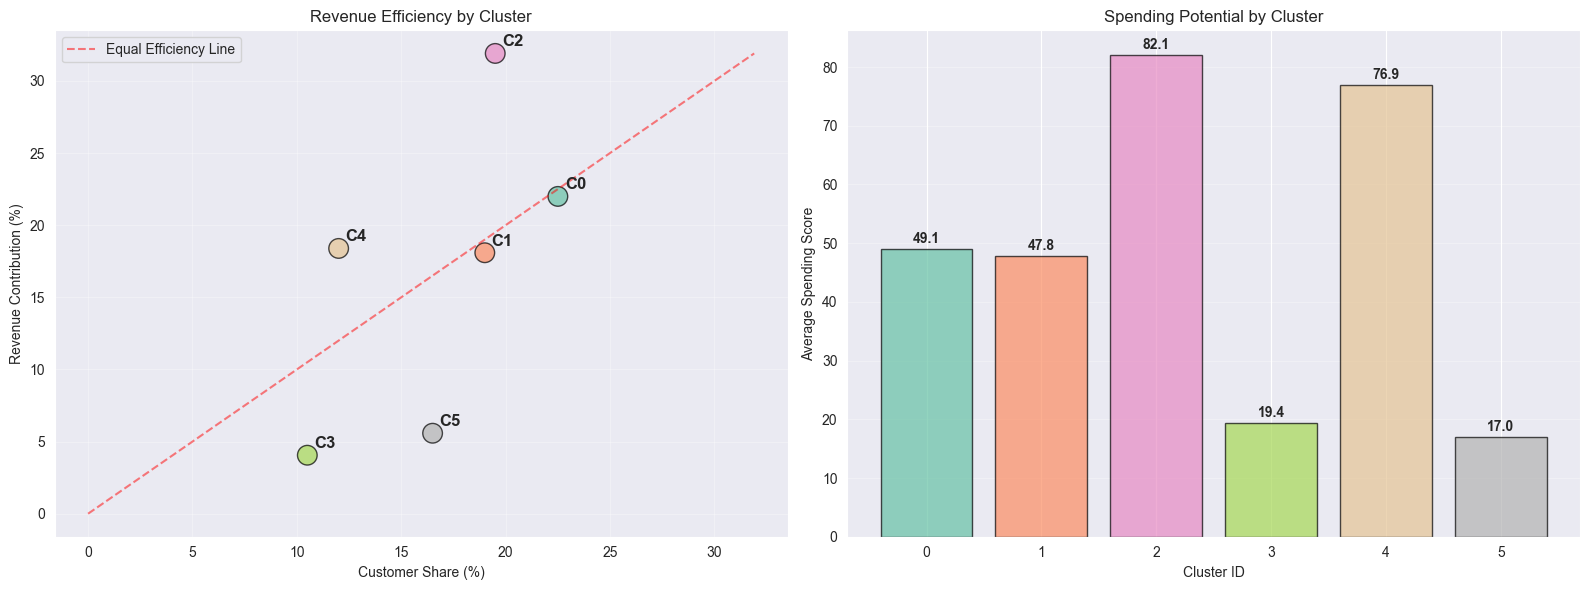


STRATEGIC RECOMMENDATIONS
🏆 Most Efficient Cluster: Cluster 2 (Efficiency Ratio: 1.64)
⚠️  Least Efficient Cluster: Cluster 5 (Efficiency Ratio: 0.34)
💎 Highest Spenders: Cluster 2 (Avg: 82.1)
💸 Lowest Spenders: Cluster 5 (Avg: 17.0)

Actionable Insights:
1. PROTECT & NURTURE: Focus retention efforts on Cluster 2 (highest efficiency)
2. GROWTH OPPORTUNITY: Develop strategies to increase spending in Cluster 5
3. PREMIUM FOCUS: Cluster 2 represents your premium segment - offer exclusive products/services
4. VALUE PROPOSITION: Cluster 5 needs value-focused offerings and promotions


In [37]:
# --- Revenue Potential Analysis ---
print("\n" + "="*70)
print("REVENUE POTENTIAL ANALYSIS")
print("="*70)

# Calculate total spending potential (assuming spending score correlates with actual spending)
total_customers = len(analysis_df)
cluster_revenue_potential = {}

for cluster_id in range(optimalK):
    cluster_data = analysis_df[analysis_df['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    avg_spending = cluster_data['Spending Score (1-100)'].mean()
    avg_income = cluster_data['Annual Income (k$)'].mean()

    # Calculate relative revenue contribution (as percentage of total)
    total_spending_score = analysis_df['Spending Score (1-100)'].sum()
    cluster_total_spending = cluster_data['Spending Score (1-100)'].sum()
    revenue_contribution = (cluster_total_spending / total_spending_score) * 100

    cluster_revenue_potential[cluster_id] = {
        'size': cluster_size,
        'avg_spending': avg_spending,
        'avg_income': avg_income,
        'revenue_contribution': revenue_contribution,
        'customer_percentage': (cluster_size / total_customers) * 100
    }

    print(f"\nCluster {cluster_id} Revenue Analysis:")
    print(f"  • Customer Share: {(cluster_size / total_customers) * 100:.1f}% ({cluster_size} customers)")
    print(f"  • Revenue Contribution: {revenue_contribution:.1f}%")
    print(f"  • Revenue per Customer: {avg_spending:.1f} (index)")
    print(f"  • Income Capacity: {avg_income:.1f}k$")
    print(f"  • Efficiency Ratio: {revenue_contribution / (cluster_size / total_customers * 100):.2f}")

# Create a summary visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Revenue contribution vs customer share
clusters = list(range(optimalK))
customer_share = [cluster_revenue_potential[i]['customer_percentage'] for i in clusters]
revenue_contribution = [cluster_revenue_potential[i]['revenue_contribution'] for i in clusters]

axes[0].scatter(customer_share, revenue_contribution, s=200, c=colors[:optimalK], alpha=0.7, edgecolors='black')

# Add cluster labels
for i, (x, y) in enumerate(zip(customer_share, revenue_contribution)):
    axes[0].annotate(f'C{i}', (x, y), xytext=(5, 5), textcoords='offset points',
                    fontsize=12, fontweight='bold')

# Add diagonal line (equal efficiency)
max_val = max(max(customer_share), max(revenue_contribution))
axes[0].plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Equal Efficiency Line')

axes[0].set_xlabel('Customer Share (%)')
axes[0].set_ylabel('Revenue Contribution (%)')
axes[0].set_title('Revenue Efficiency by Cluster')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Spending potential by cluster
spending_potential = [cluster_revenue_potential[i]['avg_spending'] for i in clusters]
bars = axes[1].bar(clusters, spending_potential, color=colors[:optimalK], alpha=0.7, edgecolor='black')

for bar, value in zip(bars, spending_potential):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Average Spending Score')
axes[1].set_title('Spending Potential by Cluster')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Final recommendations
print(f"\n" + "="*70)
print("STRATEGIC RECOMMENDATIONS")
print("="*70)

# Find highest and lowest performing clusters
best_efficiency = max([(i, cluster_revenue_potential[i]['revenue_contribution'] / cluster_revenue_potential[i]['customer_percentage'])
                      for i in range(optimalK)], key=lambda x: x[1])
worst_efficiency = min([(i, cluster_revenue_potential[i]['revenue_contribution'] / cluster_revenue_potential[i]['customer_percentage'])
                       for i in range(optimalK)], key=lambda x: x[1])

highest_spender = max(range(optimalK), key=lambda x: spending_analysis.loc[x, 'mean'])
lowest_spender = min(range(optimalK), key=lambda x: spending_analysis.loc[x, 'mean'])

print(f"🏆 Most Efficient Cluster: Cluster {best_efficiency[0]} (Efficiency Ratio: {best_efficiency[1]:.2f})")
print(f"⚠️  Least Efficient Cluster: Cluster {worst_efficiency[0]} (Efficiency Ratio: {worst_efficiency[1]:.2f})")
print(f"💎 Highest Spenders: Cluster {highest_spender} (Avg: {spending_analysis.loc[highest_spender, 'mean']:.1f})")
print(f"💸 Lowest Spenders: Cluster {lowest_spender} (Avg: {spending_analysis.loc[lowest_spender, 'mean']:.1f})")

print(f"\nActionable Insights:")
print(f"1. PROTECT & NURTURE: Focus retention efforts on Cluster {best_efficiency[0]} (highest efficiency)")
print(f"2. GROWTH OPPORTUNITY: Develop strategies to increase spending in Cluster {worst_efficiency[0]}")
print(f"3. PREMIUM FOCUS: Cluster {highest_spender} represents your premium segment - offer exclusive products/services")
print(f"4. VALUE PROPOSITION: Cluster {lowest_spender} needs value-focused offerings and promotions")
